In [424]:
import sys

sys.path.append("../")  # go to parent dir

import os
from collections.abc import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.figure import Figure

# from utils.data_clean import filter_outliers

DATA_SRC = os.path.join("..", "Data")

path = os.path.join(DATA_SRC, "CSV", "train.csv")

data_df = pd.read_csv(path)


def filter_bad_data(df):
    return df[
        (df["Physical-BMI"] > 0)
        & (df["BIA-BIA_Fat"] > 0)
        & (df["Physical-HeartRate"] > 10)
        & (df["Physical-Systolic_BP"] > 10)
        & (df["PCIAT-PCIAT_Total"].between(0, 100))
    ]


def filter_outliers(df: pd.DataFrame, column: list[str], percentile: float = 0.95) -> pd.DataFrame:
    min_percentil = (1 - percentile) / 2
    max_percentil = percentile + min_percentil

    final_df = df

    for col in column:
        min_value = df[col].quantile(min_percentil)
        max_value = df[col].quantile(max_percentil)
        final_df = final_df[(final_df[col] > min_value) & (final_df[col] < max_value)]

    return final_df


data_df = filter_bad_data(data_df)


# Estudios Individuales


In [425]:
compare_functions: list[Callable[[dict[str, pd.DataFrame], Axes], None]] = []


## Carlos


### Estudio X


In [426]:
file_path_train = "../Data/CSV/train.csv"
df_train = pd.read_csv(file_path_train)

file_path_test = "../Data/CSV/test.csv"
df_test = pd.read_csv(file_path_test)

file_path_dictionary = "../Data/CSV/data_dictionary.csv"
df_dictionary = pd.read_csv(file_path_dictionary)


In [427]:
# Función que nos ayuda a ver características de forma rápida de las columnas que se les pasa.
def calculate_stats_with_nulls(dataframe, columns):
    stats = []
    for column in columns:
        if column in dataframe.columns:
            col_stats = dataframe[column].describe()
            col_stats = col_stats.drop(["unique", "top", "freq"], errors="ignore")

            nulls = dataframe[column].isna().sum()
            col_stats["nulls"] = nulls

            stats.append(col_stats)
        else:
            stats.append(pd.Series({"count": 0, "nulls": "Column not found"}))

    result = pd.DataFrame(stats, index=columns)
    return result


### `PCIAT y sii`

In [428]:
# Ver intervalos de los valores máximos y mínimos para sii y PCIAT_total_Score
pciat_min_max = df_train.groupby("sii", as_index=False)["PCIAT-PCIAT_Total"].agg(
    PCIAT_Total_Score_Mínimo="min", PCIAT_Total_Score_Máximo="max"
)

print(pciat_min_max)

# ¿ Habrá algún cuestionario sin responder ?
pciat_columns = [
    col
    for col in df_train.columns
    if col.startswith("PCIAT-PCIAT") and col not in ["PCIAT-Season", "PCIAT-PCIAT_Total"]
]

total_nulls = df_train[pciat_columns].isnull().sum().sum()
print(f"El número total de valores nulos en las columnas seleccionadas es: {total_nulls}")


# Ahora habrá que ver si al menos hay cuestionarios sensibles o no
pciat_columns = [
    col
    for col in df_train.columns
    if col.startswith("PCIAT-PCIAT") and col not in ["PCIAT-Season", "PCIAT-PCIAT_Total"]
]

relevant_data = df_train[pciat_columns]
rows_with_nulls = relevant_data.isnull().any(axis=1)

rows_with_nulls_data = relevant_data[rows_with_nulls]
fixed_values = rows_with_nulls_data.fillna(0).sum(axis=1)
num_nulls = rows_with_nulls_data.isnull().sum(axis=1)

possible_min = fixed_values  # Cuando los nulos son todos 0
possible_max = fixed_values + num_nulls * 5  # Cuando los nulos son todos 5

sii_intervals = [(0, 0, 30), (1, 31, 49), (2, 50, 79), (3, 80, 93)]


def crosses_interval(min_val, max_val):
    for sii, min_bound, max_bound in sii_intervals:
        if min_val <= max_bound and max_val >= min_bound:
            return True
    return False


problematic_cases = [
    crosses_interval(min_val, max_val) for min_val, max_val in zip(possible_min, possible_max)
]


num_problematic_cases = np.sum(problematic_cases)
print(f"Número de casos problemáticos: {num_problematic_cases}")


   sii  PCIAT_Total_Score_Mínimo  PCIAT_Total_Score_Máximo
0  0.0                       0.0                      30.0
1  1.0                      31.0                      49.0
2  2.0                      50.0                      79.0
3  3.0                      80.0                      93.0
El número total de valores nulos en las columnas seleccionadas es: 24588
Número de casos problemáticos: 1289


In [429]:
# Verificar si los rangos cruzan intervalos, estas serán las filas en las que tendremos que ahcer algo.
problematic_rows = [
    crosses_interval(min_val, max_val) for min_val, max_val in zip(possible_min, possible_max)
]

# Contar las filas problemáticas
num_problematic_rows = np.sum(problematic_rows)
problematic_indices = rows_with_nulls_data.index[problematic_rows]

print(f"Número de filas problemáticas: {num_problematic_rows}")
print(f"Índices de filas problemáticas: {list(problematic_indices)}")


Número de filas problemáticas: 1289
Índices de filas problemáticas: [4, 7, 8, 9, 10, 13, 14, 17, 19, 24, 29, 30, 32, 33, 34, 35, 37, 39, 40, 42, 43, 47, 65, 67, 69, 71, 73, 76, 78, 84, 87, 93, 95, 102, 104, 107, 110, 123, 126, 127, 136, 138, 141, 142, 143, 148, 151, 156, 159, 160, 162, 163, 169, 171, 175, 177, 185, 187, 194, 203, 207, 211, 213, 215, 221, 229, 237, 240, 241, 246, 247, 251, 252, 253, 254, 255, 258, 259, 263, 264, 266, 270, 272, 274, 275, 279, 280, 283, 288, 289, 290, 293, 295, 298, 305, 308, 311, 312, 313, 314, 317, 320, 323, 326, 327, 332, 337, 340, 344, 345, 362, 363, 366, 368, 371, 372, 373, 375, 378, 385, 386, 387, 390, 395, 397, 401, 402, 403, 406, 409, 411, 412, 414, 415, 416, 422, 425, 427, 435, 437, 440, 442, 443, 447, 448, 449, 450, 452, 453, 456, 457, 460, 467, 471, 475, 476, 478, 479, 481, 483, 486, 494, 499, 500, 501, 502, 507, 509, 512, 519, 524, 525, 526, 535, 536, 541, 542, 545, 546, 547, 552, 553, 559, 561, 564, 573, 576, 577, 578, 582, 585, 586, 589, 592

In [430]:
# Algunos ni sabemos en que estación del año está
has_null_in_season = df_train["PCIAT-Season"].isnull().any()
print(f"¿Alguna fila tiene la columna 'PCIAT-PCIAT-Season' en null? {has_null_in_season}")


¿Alguna fila tiene la columna 'PCIAT-PCIAT-Season' en null? True



#### Porcentajes de sii, y distribución del PCIAT total

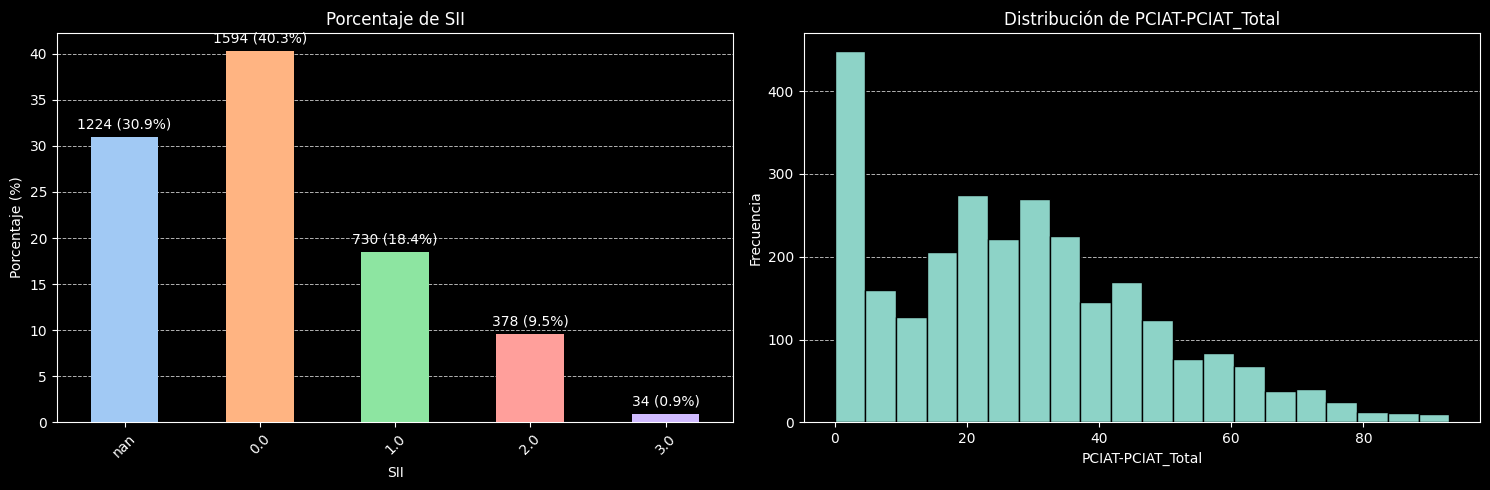

In [ ]:
sii_counts = df_train["sii"].value_counts(dropna=False)
sii_percentages = (sii_counts / sii_counts.sum()) * 100

sii_counts = sii_counts.sort_index(na_position="first")
sii_percentages = sii_percentages.loc[sii_counts.index]

pciat_total_values = df_train["PCIAT-PCIAT_Total"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

colors = sns.color_palette("pastel", len(sii_percentages))
sii_percentages.plot(kind="bar", ax=axes[0], zorder=3, color=colors)

axes[0].set_title("Porcentaje de SII")
axes[0].set_xlabel("SII")
axes[0].set_ylabel("Porcentaje (%)")
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7, zorder=0)
axes[0].tick_params(axis="x", rotation=45)

for index, value in enumerate(sii_percentages):
    axes[0].text(index, value + 1, f"{sii_counts.iloc[index]} ({value:.1f}%)", ha="center")

pciat_total_values.plot(kind="hist", bins=20, ax=axes[1], edgecolor="black", zorder=3)

axes[1].set_title("Distribución de PCIAT-PCIAT_Total")
axes[1].set_xlabel("PCIAT-PCIAT_Total")
axes[1].set_ylabel("Frecuencia")
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7, zorder=0)

plt.tight_layout()
plt.show()


#### Distribución del sii y PCIAT Total según el rango de edad

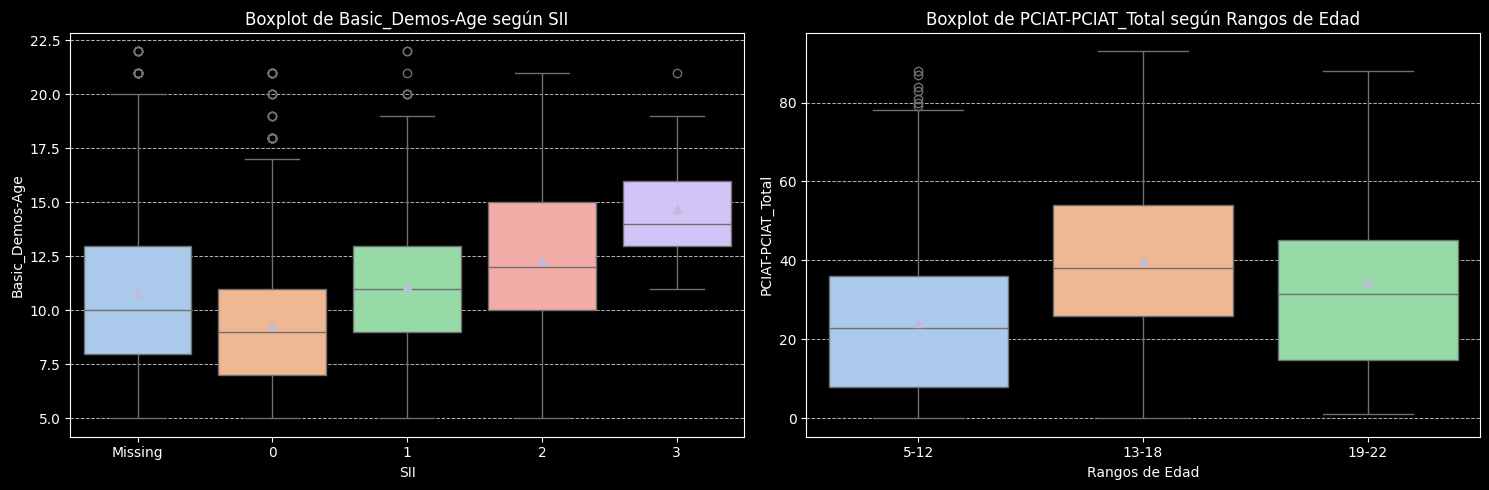

In [ ]:
df_train["sii_categ"] = df_train["sii"].fillna("Missing")
labels = ["5-12", "13-18", "19-22"]

df_train["sii_categ"] = pd.Categorical(
    df_train["sii_categ"], categories=["Missing", 0, 1, 2, 3], ordered=True
)

df_train["Edad_Rango"] = pd.cut(df_train["Basic_Demos-Age"], bins=[4, 12, 18, 22], labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(
    x="sii_categ",
    y="Basic_Demos-Age",
    data=df_train,
    hue="sii_categ",
    ax=axes[0],
    showmeans=True,
    palette="pastel",
    dodge=False,
    legend=False,
)
axes[0].set_title("Boxplot de Basic_Demos-Age según SII")
axes[0].set_xlabel("SII")
axes[0].set_ylabel("Basic_Demos-Age")
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.boxplot(
    x="Edad_Rango",
    y="PCIAT-PCIAT_Total",
    data=df_train,
    hue="Edad_Rango",
    ax=axes[1],
    showmeans=True,
    palette="pastel",
    dodge=False,
    legend=False,
)
axes[1].set_title("Boxplot de PCIAT-PCIAT_Total según Rangos de Edad")
axes[1].set_xlabel("Rangos de Edad")
axes[1].set_ylabel("PCIAT-PCIAT_Total")
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Distribución del PCIAT Total según el sexo

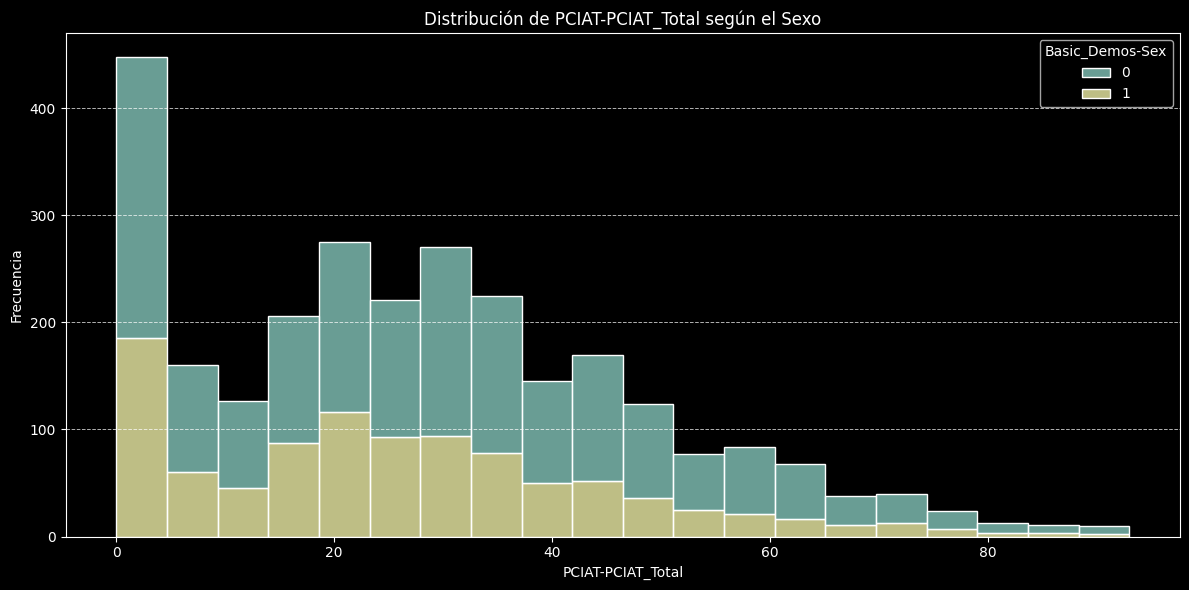

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(
    data=df_train,
    x="PCIAT-PCIAT_Total",
    hue="Basic_Demos-Sex",
    multiple="stack",
    palette="Set3",
    bins=20,
    ax=ax,
)

ax.set_title("Distribución de PCIAT-PCIAT_Total según el Sexo")
ax.set_xlabel("PCIAT-PCIAT_Total")
ax.set_ylabel("Frecuencia")
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Resultados sii según edad en gráficos pastel

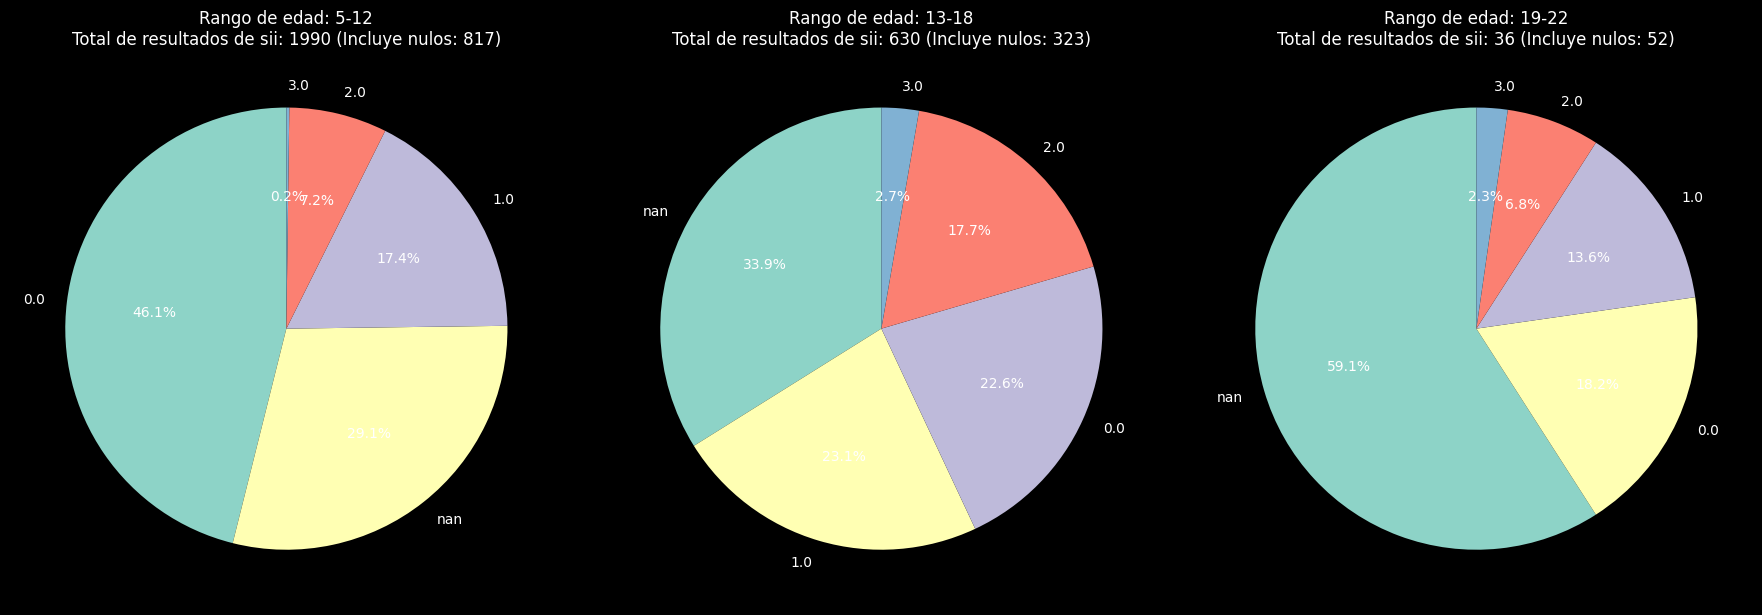

In [ ]:
bins = [5, 12, 18, 22]
df_train["Edad_Rango"] = pd.cut(df_train["Basic_Demos-Age"], bins=bins, labels=labels, right=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, rango in enumerate(labels):
    grupo = df_train[df_train["Edad_Rango"] == rango]

    sii_counts = grupo["sii"].value_counts(normalize=True, dropna=False) * 100
    sii_labels = sii_counts.index
    sii_values = sii_counts.values

    titulo = f"Rango de edad: {rango}\nTotal de resultados de sii: {grupo['sii'].count()} (Incluye nulos: {grupo['sii'].isna().sum()})"

    axes[i].pie(
        sii_values,
        labels=sii_labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette("Set3"),
    )
    axes[i].set_title(titulo)

plt.tight_layout()
plt.show()


#### Estación del año en el que fue realizado los tipo test PCIAT

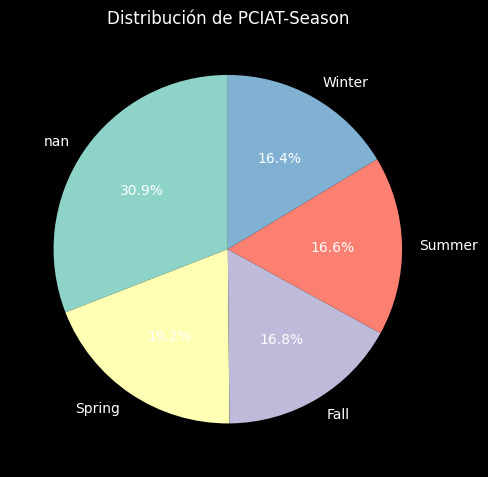

In [ ]:
season_counts = df_train["PCIAT-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de PCIAT-Season")

plt.tight_layout()
plt.show()


### `Demographics`

In [436]:
# Vamos a ver el rango de edades:
unique_ages = sorted(df_train["Basic_Demos-Age"].dropna().unique().tolist())
unique_ages


[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

#### Número de participantes según edad y sexo

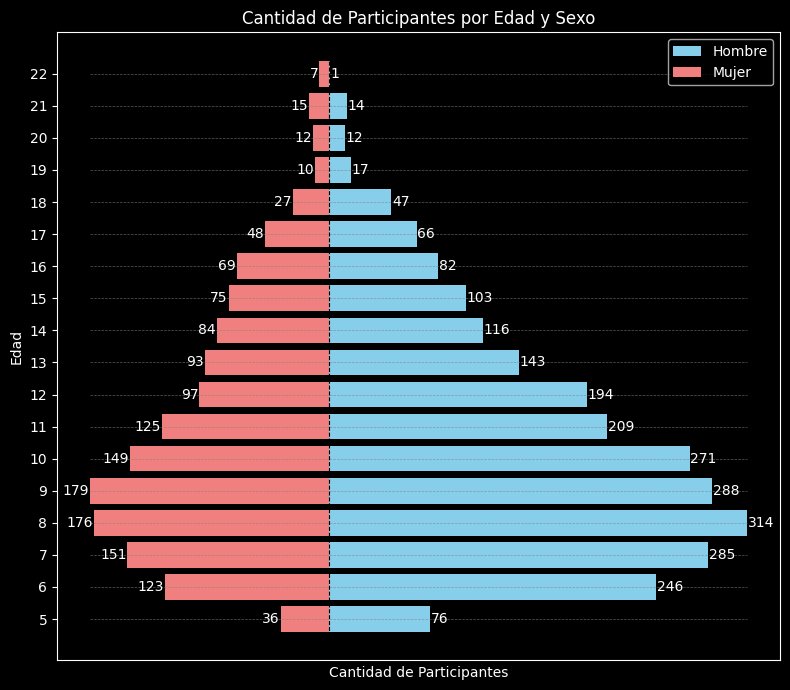

In [ ]:
gender_age_counts = (
    df_train.groupby(["Basic_Demos-Age", "Basic_Demos-Sex"]).size().unstack(fill_value=0)
)

ages = sorted(df_train["Basic_Demos-Age"].dropna().unique())
male_counts = gender_age_counts.reindex(ages, fill_value=0).get(0, [0] * len(ages))
female_counts = gender_age_counts.reindex(ages, fill_value=0).get(1, [0] * len(ages))

fig, ax = plt.subplots(figsize=(8, 7))

male_bars = ax.barh(ages, male_counts, color="skyblue", label="Hombre")
female_bars = ax.barh(ages, -female_counts, color="lightcoral", label="Mujer")  # type: ignore


for bar in male_bars:
    width = bar.get_width()
    ax.text(
        width + 0.5, bar.get_y() + bar.get_height() / 2, f"{int(width)}", va="center", ha="left"
    )
for bar in female_bars:
    width = abs(bar.get_width())
    ax.text(
        -width - 0.5, bar.get_y() + bar.get_height() / 2, f"{int(width)}", va="center", ha="right"
    )


for age in ages:
    ax.hlines(
        y=age,
        xmin=-max(female_counts),
        xmax=max(male_counts),
        color="gray",
        linestyle="--",
        linewidth=0.5,
        alpha=0.7,
    )


ax.set_title("Cantidad de Participantes por Edad y Sexo")
ax.set_xlabel("Cantidad de Participantes")
ax.set_ylabel("Edad")
ax.set_yticks(ages)
ax.axvline(0, color="black", linewidth=0.8, linestyle="--")
ax.legend()
ax.set_xticks([])

plt.tight_layout()
plt.show()


#### Número de participantes según el sexo

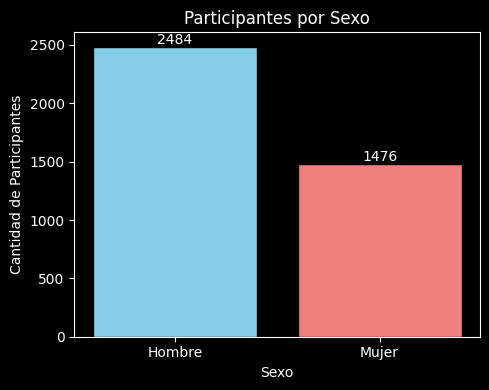

In [ ]:
gender_counts = df_train["Basic_Demos-Sex"].value_counts()
gender_values = gender_counts.to_numpy()

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(
    ["Hombre", "Mujer"], gender_values, color=["skyblue", "lightcoral"], edgecolor="black"
)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 2, f"{int(height)}", ha="center", va="bottom"
    )

ax.set_title("Participantes por Sexo")
ax.set_xlabel("Sexo")
ax.set_ylabel("Cantidad de Participantes")

plt.tight_layout()
plt.show()


#### Estación del año de participación según el sexo

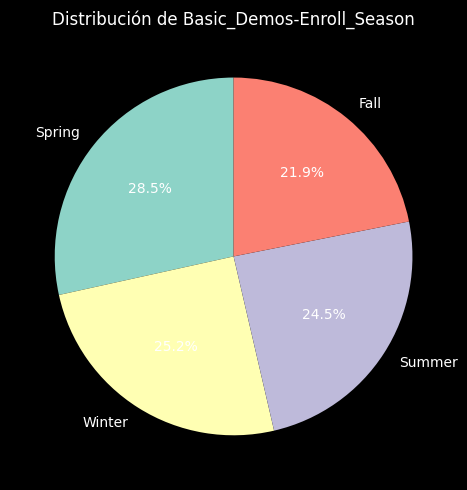

In [ ]:
season_counts = (
    df_train["Basic_Demos-Enroll_Season"].value_counts(normalize=True, dropna=False) * 100
)

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de Basic_Demos-Enroll_Season")

plt.tight_layout()
plt.show()


### `Children Global Assesment Scale(CGAS)`

In [440]:
stats = df_train["CGAS-CGAS_Score"].describe()

nulls = df_train["CGAS-CGAS_Score"].isna().sum()

stats_with_nulls = pd.concat([stats, pd.Series({"nulls": nulls})])


def conditional_round(x):
    if isinstance(x, (int, float)) and x == round(x):
        return f"{x:.1f}"
    return x


stats_with_nulls = stats_with_nulls.apply(conditional_round)

print(stats_with_nulls)


count       2421.0
mean     65.454771
std      22.341862
min           25.0
25%           59.0
50%           65.0
75%           75.0
max          999.0
nulls       1539.0
dtype: object


In [441]:
# Contar los valores por encima de 100, ya que eso es obviamente un fallo
outliers_count = df_train[df_train["CGAS-CGAS_Score"] > 100].shape[0]
print(f"Número de valores por encima de 100: {outliers_count}")


Número de valores por encima de 100: 1


`NOTA`: Enlace a a la página para comparar CGAS: https://www.corc.uk.net/outcome-experience-measures/childrens-global-assessment-scale-cgas/

#### Distribución de la puntuación de CGAS según categorías

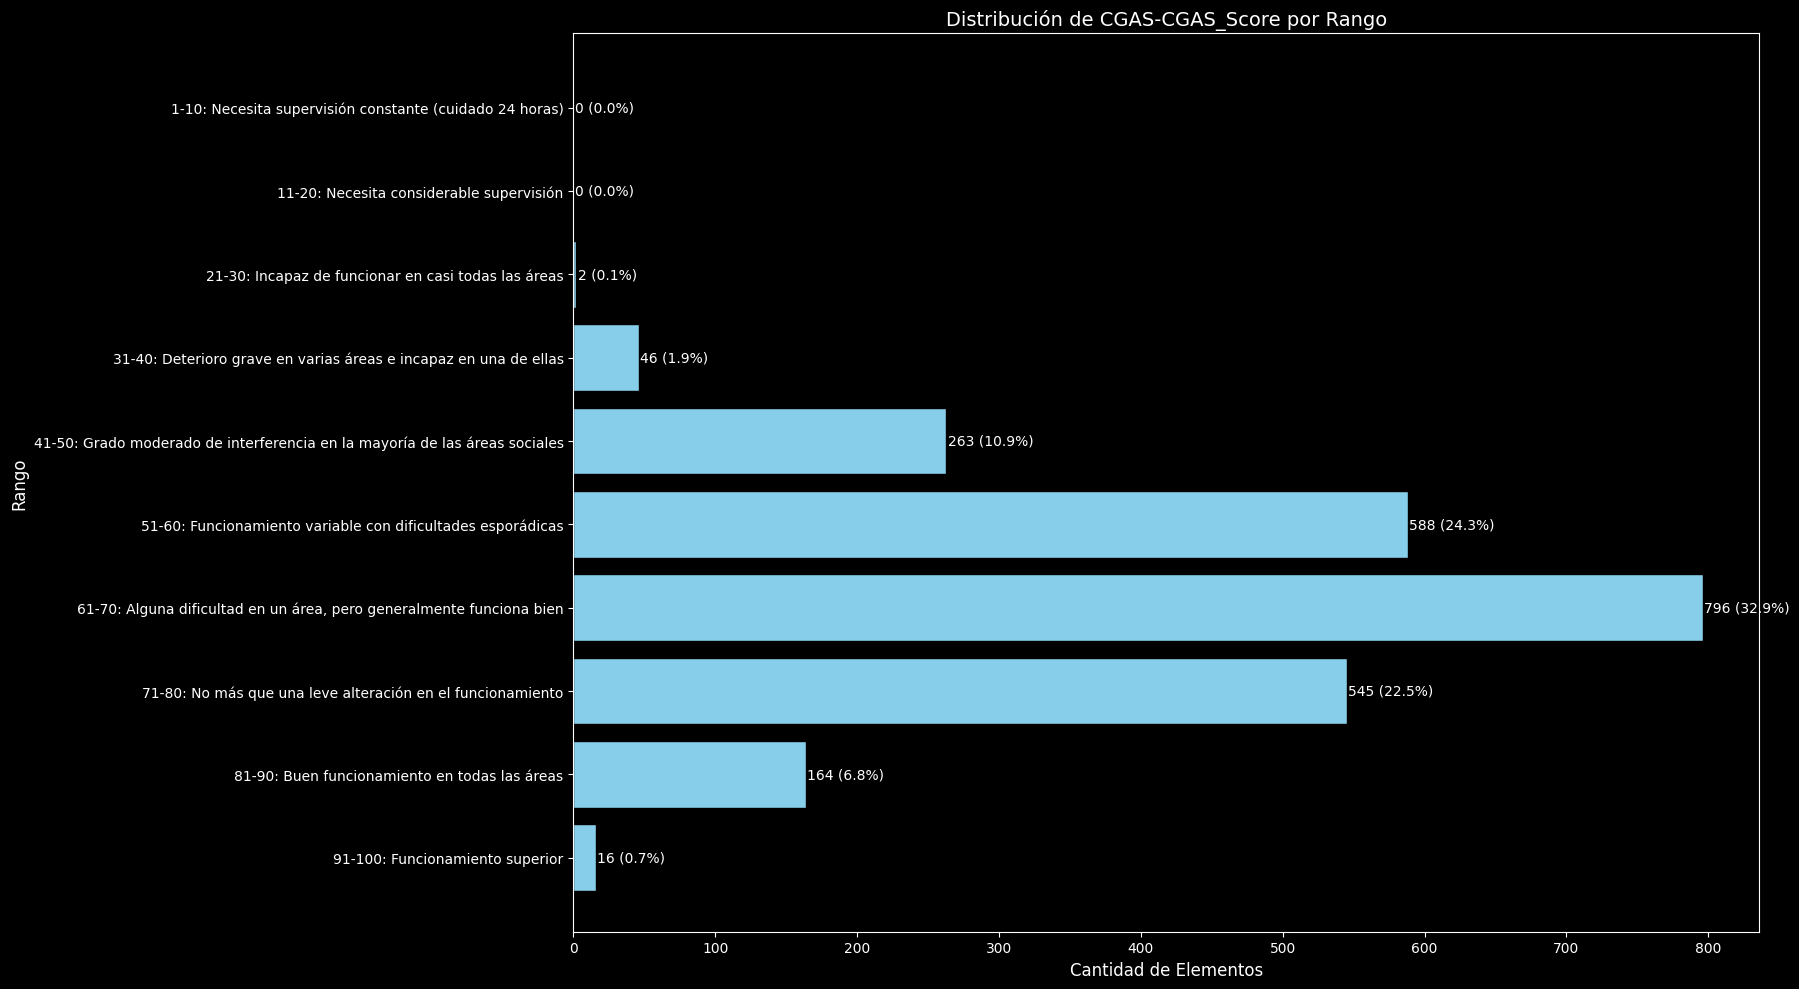

In [ ]:
ranges = [
    (1, 10),
    (11, 20),
    (21, 30),
    (31, 40),
    (41, 50),
    (51, 60),
    (61, 70),
    (71, 80),
    (81, 90),
    (91, 100),
]

labels = [
    "1-10: Necesita supervisión constante (cuidado 24 horas)",
    "11-20: Necesita considerable supervisión",
    "21-30: Incapaz de funcionar en casi todas las áreas",
    "31-40: Deterioro grave en varias áreas e incapaz en una de ellas",
    "41-50: Grado moderado de interferencia en la mayoría de las áreas sociales",
    "51-60: Funcionamiento variable con dificultades esporádicas",
    "61-70: Alguna dificultad en un área, pero generalmente funciona bien",
    "71-80: No más que una leve alteración en el funcionamiento",
    "81-90: Buen funcionamiento en todas las áreas",
    "91-100: Funcionamiento superior",
]

counts = []
for low, high in ranges:
    count = df_train["CGAS-CGAS_Score"].between(low, high, inclusive="both").sum()
    counts.append(count)

total = sum(counts)
percentages = [(count / total) * 100 for count in counts]
data = pd.DataFrame({"Rango": labels, "Cantidad": counts, "Porcentaje": percentages})

data["Orden"] = range(len(data))
data = data.sort_values("Orden", ascending=False)

fig, ax = plt.subplots(figsize=(18, 10))
bars = ax.barh(data["Rango"], data["Cantidad"], color="skyblue", edgecolor="black")

for index, bar in enumerate(bars):
    width = bar.get_width()
    percentage = data["Porcentaje"].iloc[index]
    ax.text(
        width + 1,
        bar.get_y() + bar.get_height() / 2,
        f"{int(width)} ({percentage:.1f}%)",
        va="center",
        ha="left",
    )

ax.set_title("Distribución de CGAS-CGAS_Score por Rango", fontsize=14)
ax.set_xlabel("Cantidad de Elementos", fontsize=12)
ax.set_ylabel("Rango", fontsize=12)

plt.tight_layout()
plt.show()


#### Puntuación CGAS según el sii

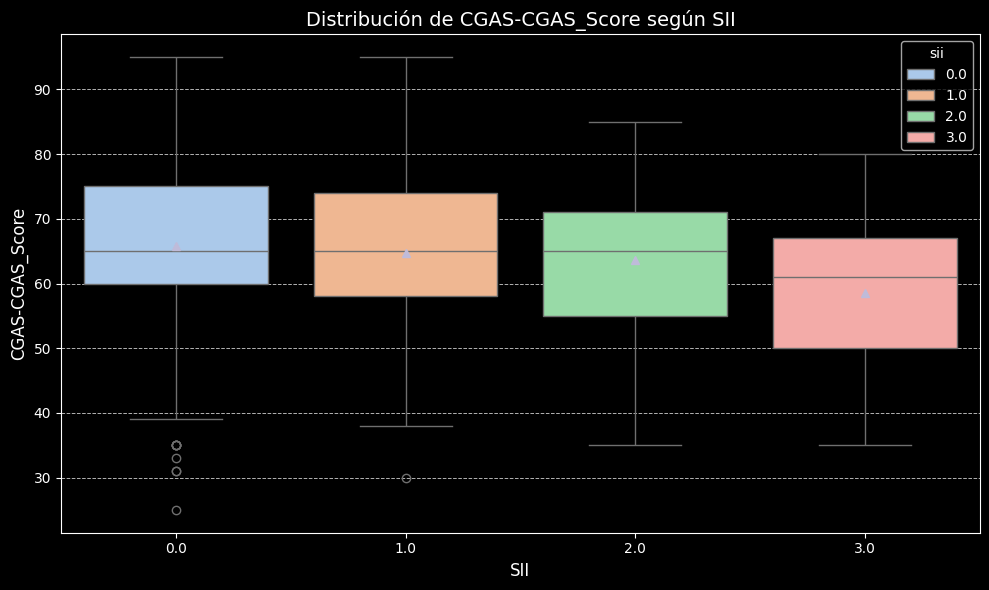

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="sii",
    y="CGAS-CGAS_Score",
    data=df_train,
    ax=ax,
    showmeans=True,
    palette="pastel",
    hue="sii",
)

ax.set_title("Distribución de CGAS-CGAS_Score según SII", fontsize=14)
ax.set_xlabel("SII", fontsize=12)
ax.set_ylabel("CGAS-CGAS_Score", fontsize=12)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Distribución de PCIAT según categoría de CGAS

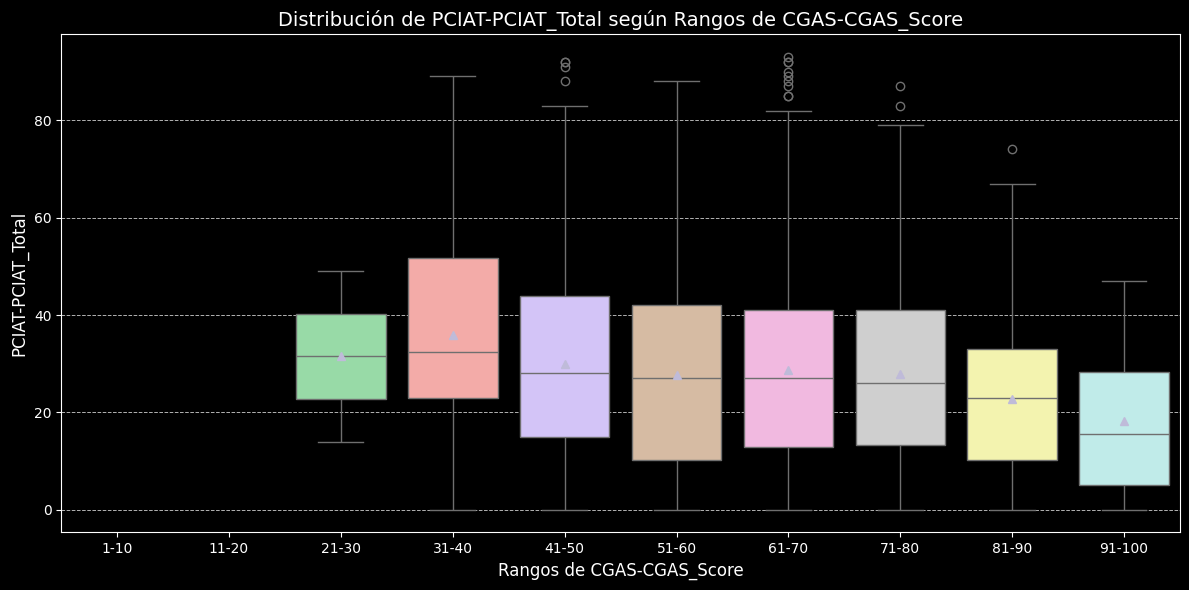

In [ ]:
labels = ["1-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"]

df_train["CGAS_Range"] = pd.cut(
    df_train["CGAS-CGAS_Score"],
    bins=[low - 0.1 for low, _ in ranges] + [ranges[-1][1] + 0.1],
    labels=labels,
    right=True,
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    x="CGAS_Range",
    y="PCIAT-PCIAT_Total",
    data=df_train,
    ax=ax,
    showmeans=True,
    palette="pastel",
    hue="CGAS_Range",
    dodge=False,
)

ax.get_legend().remove()
ax.set_title("Distribución de PCIAT-PCIAT_Total según Rangos de CGAS-CGAS_Score", fontsize=14)
ax.set_xlabel("Rangos de CGAS-CGAS_Score", fontsize=12)
ax.set_ylabel("PCIAT-PCIAT_Total", fontsize=12)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Estación del año correspondiente a la medida del CGAS

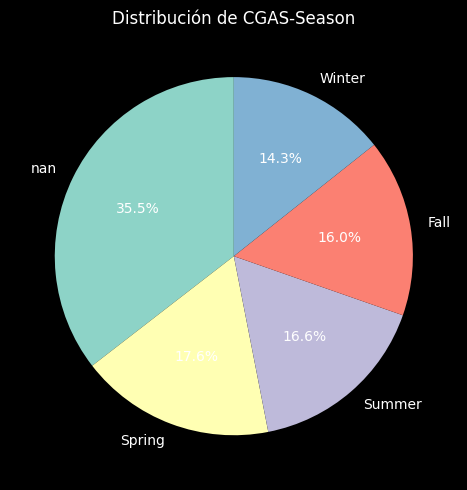

In [ ]:
season_counts = df_train["CGAS-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de CGAS-Season")

plt.tight_layout()
plt.show()


### ` Physical Measures`

In [ ]:
# Vemos rápidamente algunas caráterísticas de las columnas
columns_to_analyze = [
    "Physical-BMI",
    "Physical-Height",
    "Physical-Weight",
    "Physical-Waist_Circumference",
    "Physical-Diastolic_BP",
    "Physical-HeartRate",
    "Physical-Systolic_BP",
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                               count        mean        std   min        25%  \
Physical-BMI                  3022.0   19.331929   5.113934   0.0   15.86935   
Physical-Height               3027.0   55.946713   7.473764  33.0   50.00000   
Physical-Weight               3076.0   89.038615  44.569040   0.0   57.20000   
Physical-Waist_Circumference   898.0   27.278508   5.567287  18.0   23.00000   
Physical-Diastolic_BP         2954.0   69.648951  13.611226   0.0   61.00000   
Physical-HeartRate            2967.0   81.597236  13.665196  27.0   72.00000   
Physical-Systolic_BP          2954.0  116.983074  17.061225   0.0  107.00000   

                                     50%         75%         max   nulls  
Physical-BMI                   17.937682   21.571244   59.132048   938.0  
Physical-Height                55.000000   62.000000   78.500000   933.0  
Physical-Weight                77.000000  113.800000  315.000000   884.0  
Physical-Waist_Circumference   26.000000   30.000000   50.0

#### Histograma de las medidas físicas

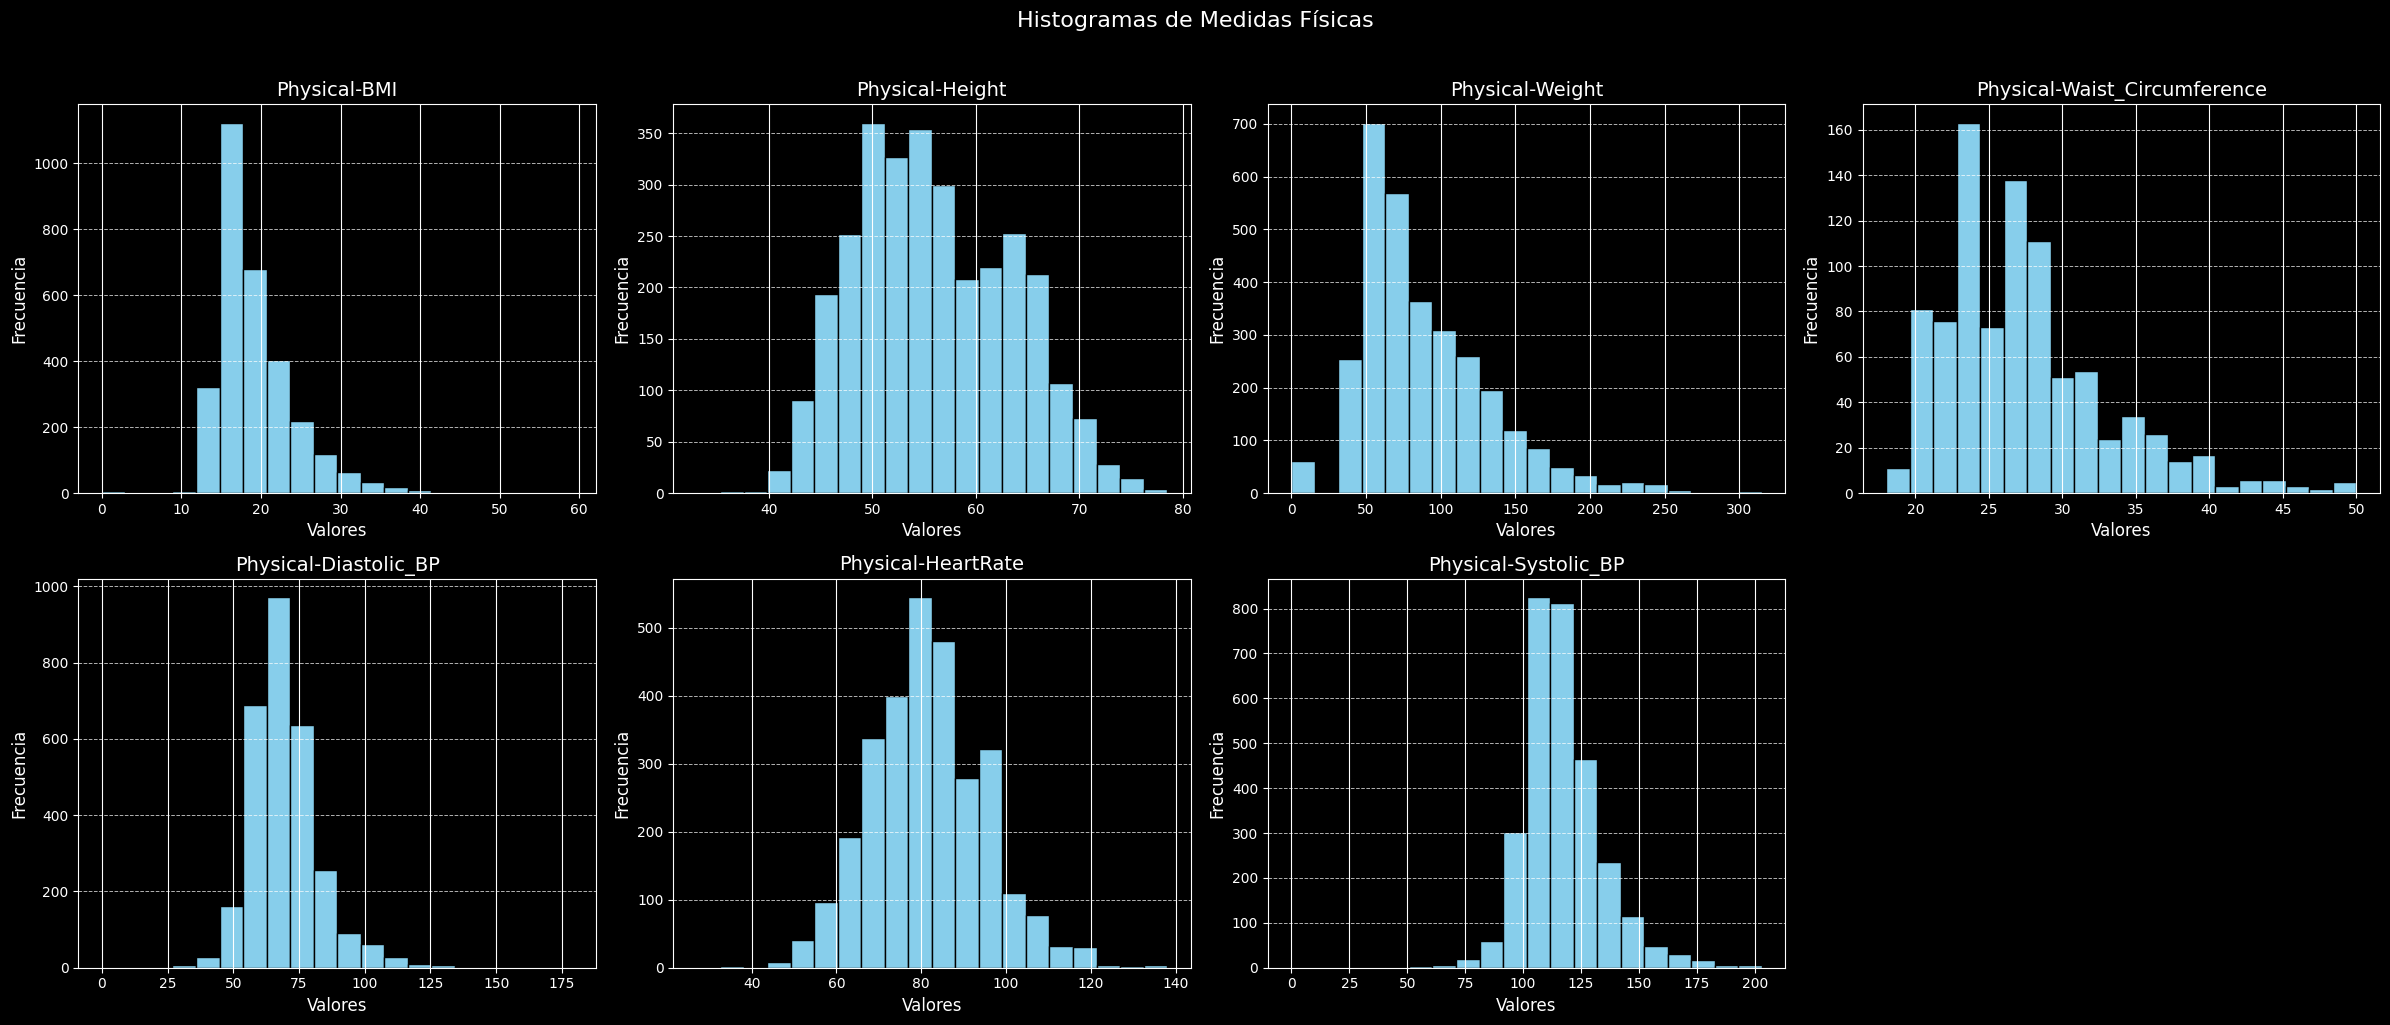

In [ ]:
plt.figure(figsize=(24, 10))
n_cols = 4
n_rows = len(columns_to_analyze) // n_cols + 1

for i, col in enumerate(columns_to_analyze):
    plt.subplot(n_rows, n_cols, i + 1)
    df_train[col].hist(bins=20, color="skyblue", edgecolor="black")
    plt.title(col, fontsize=14)
    plt.xlabel("Valores", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.suptitle("Histogramas de Medidas Físicas", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


#### Recálculo de las medidas: Pulgadas a centímetros y libras a kilogramos

In [448]:
pulgadas_a_centimetros = 2.54
libras_a_kilos = 0.453592

df_train["Physical-Height"] *= pulgadas_a_centimetros
df_train["Physical-Waist_Circumference"] *= pulgadas_a_centimetros
df_train["Physical-Weight"] *= libras_a_kilos


# Importante recalcular el BMI
df_train["Physical-BMI"] = np.where(
    df_train["Physical-Weight"].notna() & df_train["Physical-Height"].notna(),
    df_train["Physical-Weight"] / ((df_train["Physical-Height"] / 100) ** 2),
    np.nan,
)


print(df_train[["Physical-Height", "Physical-Weight", "Physical-BMI"]].head())


-3.883011439143047e-05

   Physical-Height  Physical-Weight  Physical-BMI
0           116.84        23.042474     16.878972
1           121.92        20.865232     14.036968
2           143.51        34.291555     16.650330
3           142.24        37.013107     18.294143
4              NaN              NaN           NaN


#### Peso y altura según la edad

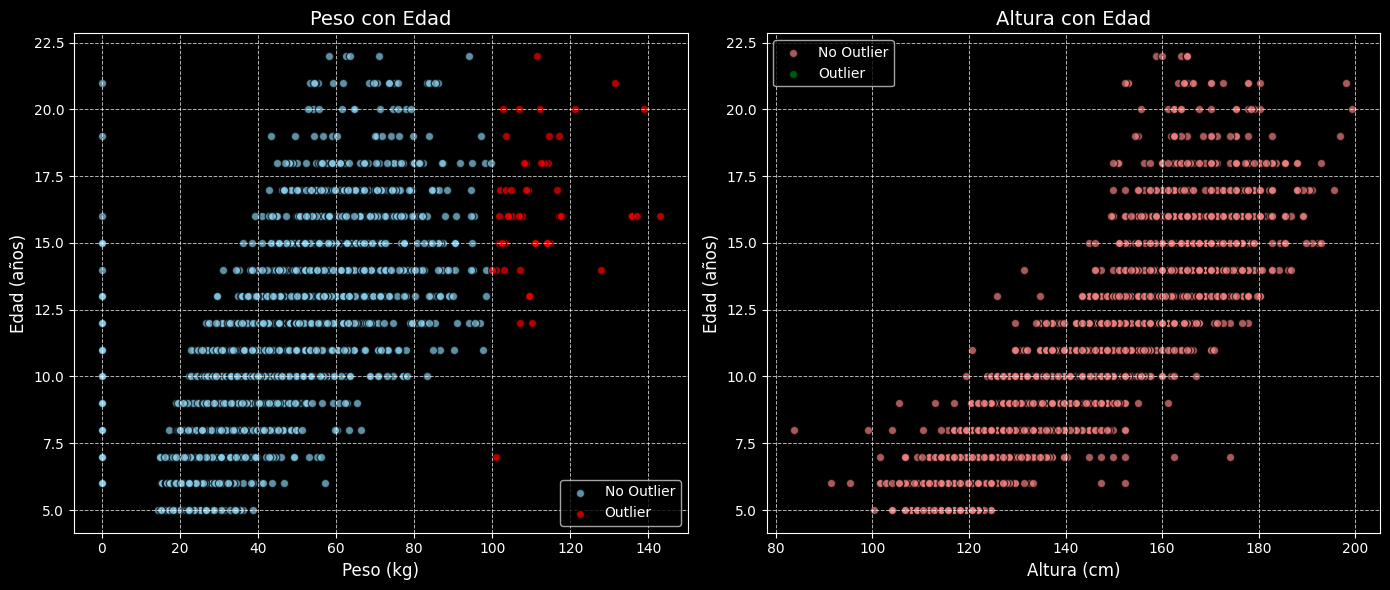

In [ ]:
# Hay que revisar los outliers aquí
df_train["Weight_Outlier"] = df_train["Physical-Weight"] > 100
df_train["Height_Outlier"] = df_train["Physical-Height"] > 200

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(
    df_train.loc[~df_train["Weight_Outlier"], "Physical-Weight"],
    df_train.loc[~df_train["Weight_Outlier"], "Basic_Demos-Age"],
    alpha=0.7,
    color="skyblue",
    label="No Outlier",
    edgecolor="black",
)
axes[0].scatter(
    df_train.loc[df_train["Weight_Outlier"], "Physical-Weight"],
    df_train.loc[df_train["Weight_Outlier"], "Basic_Demos-Age"],
    alpha=0.7,
    color="red",
    label="Outlier",
    edgecolor="black",
)
axes[0].set_title("Peso con Edad", fontsize=14)
axes[0].set_xlabel("Peso (kg)", fontsize=12)
axes[0].set_ylabel("Edad (años)", fontsize=12)
axes[0].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[0].legend()

axes[1].scatter(
    df_train.loc[~df_train["Height_Outlier"], "Physical-Height"],
    df_train.loc[~df_train["Height_Outlier"], "Basic_Demos-Age"],
    alpha=0.7,
    color="lightcoral",
    label="No Outlier",
    edgecolor="black",
)
axes[1].scatter(
    df_train.loc[df_train["Height_Outlier"], "Physical-Height"],
    df_train.loc[df_train["Height_Outlier"], "Basic_Demos-Age"],
    alpha=0.7,
    color="green",
    label="Outlier",
    edgecolor="black",
)
axes[1].set_title("Altura con Edad", fontsize=14)
axes[1].set_xlabel("Altura (cm)", fontsize=12)
axes[1].set_ylabel("Edad (años)", fontsize=12)
axes[1].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


#### Peso con Medidas de la cintura

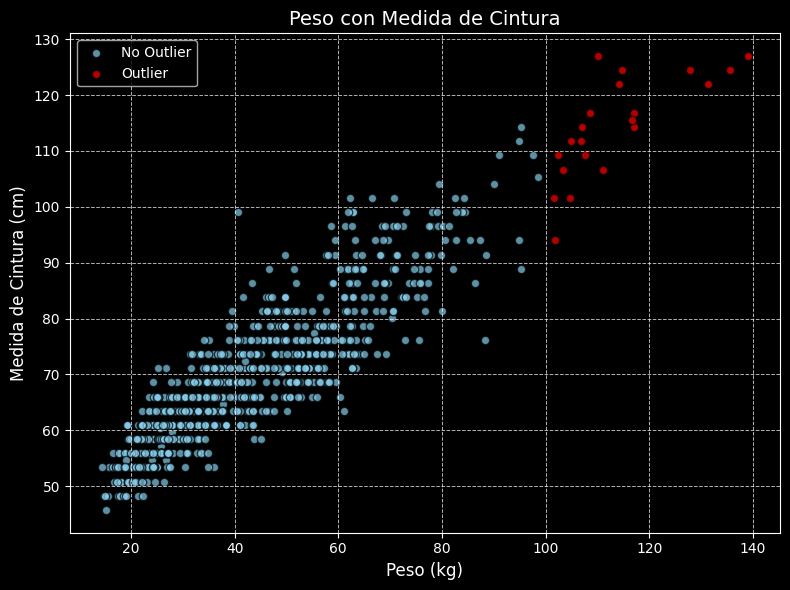

In [ ]:
# Revisar los outliers
df_train["Outlier"] = (df_train["Physical-Weight"] > 100) | (
    df_train["Physical-Waist_Circumference"] > 150
)

plt.figure(figsize=(8, 6))

plt.scatter(
    df_train.loc[~df_train["Outlier"], "Physical-Weight"],
    df_train.loc[~df_train["Outlier"], "Physical-Waist_Circumference"],
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
    label="No Outlier",
)

plt.scatter(
    df_train.loc[df_train["Outlier"], "Physical-Weight"],
    df_train.loc[df_train["Outlier"], "Physical-Waist_Circumference"],
    alpha=0.7,
    color="red",
    edgecolor="black",
    label="Outlier",
)

plt.title("Peso con Medida de Cintura", fontsize=14)
plt.xlabel("Peso (kg)", fontsize=12)
plt.ylabel("Medida de Cintura (cm)", fontsize=12)
plt.grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


#### Latidos del corazón con presión sistólica y diastólica

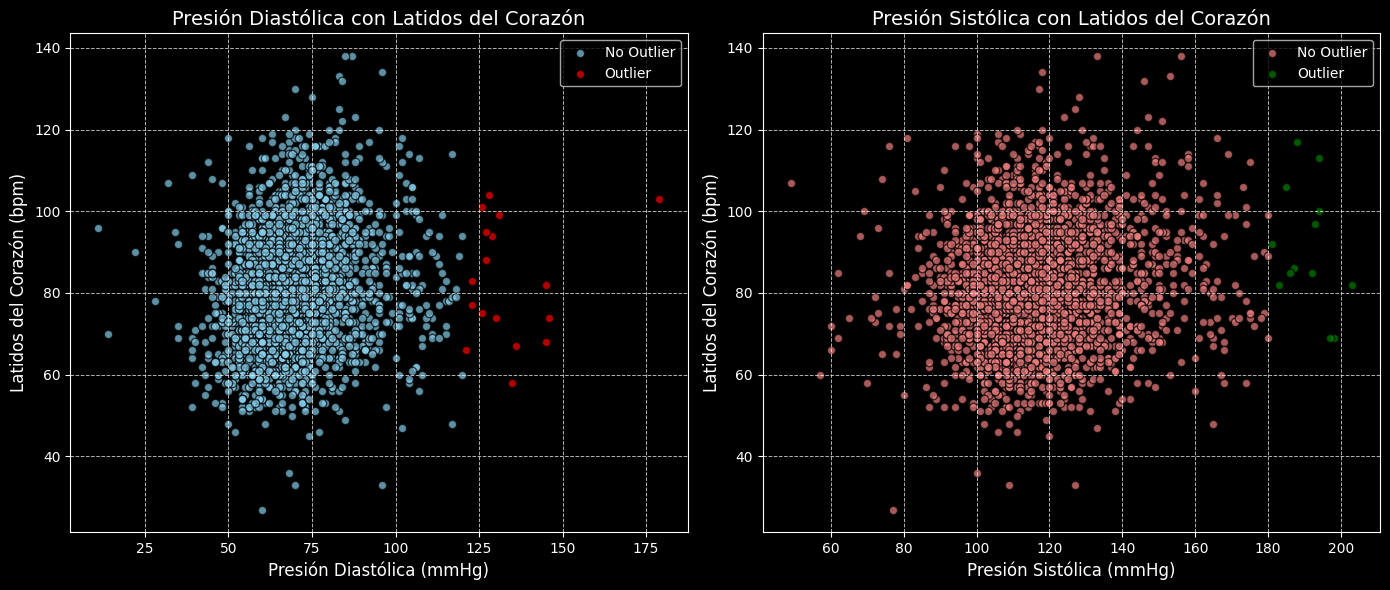

In [ ]:
# Revisar outliers
df_train["Diastolic_Outlier"] = df_train["Physical-Diastolic_BP"] > 120
df_train["Systolic_Outlier"] = df_train["Physical-Systolic_BP"] > 180
df_train["HeartRate_Outlier"] = df_train["Physical-HeartRate"] > 150

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(
    df_train.loc[~df_train["Diastolic_Outlier"], "Physical-Diastolic_BP"],
    df_train.loc[~df_train["Diastolic_Outlier"], "Physical-HeartRate"],
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
    label="No Outlier",
)
axes[0].scatter(
    df_train.loc[df_train["Diastolic_Outlier"], "Physical-Diastolic_BP"],
    df_train.loc[df_train["Diastolic_Outlier"], "Physical-HeartRate"],
    alpha=0.7,
    color="red",
    edgecolor="black",
    label="Outlier",
)
axes[0].set_title("Presión Diastólica con Latidos del Corazón", fontsize=14)
axes[0].set_xlabel("Presión Diastólica (mmHg)", fontsize=12)
axes[0].set_ylabel("Latidos del Corazón (bpm)", fontsize=12)
axes[0].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[0].legend()

axes[1].scatter(
    df_train.loc[~df_train["Systolic_Outlier"], "Physical-Systolic_BP"],
    df_train.loc[~df_train["Systolic_Outlier"], "Physical-HeartRate"],
    alpha=0.7,
    color="lightcoral",
    edgecolor="black",
    label="No Outlier",
)
axes[1].scatter(
    df_train.loc[df_train["Systolic_Outlier"], "Physical-Systolic_BP"],
    df_train.loc[df_train["Systolic_Outlier"], "Physical-HeartRate"],
    alpha=0.7,
    color="green",
    edgecolor="black",
    label="Outlier",
)
axes[1].set_title("Presión Sistólica con Latidos del Corazón", fontsize=14)
axes[1].set_xlabel("Presión Sistólica (mmHg)", fontsize=12)
axes[1].set_ylabel("Latidos del Corazón (bpm)", fontsize=12)
axes[1].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


#### Presión diastólica y sistólica

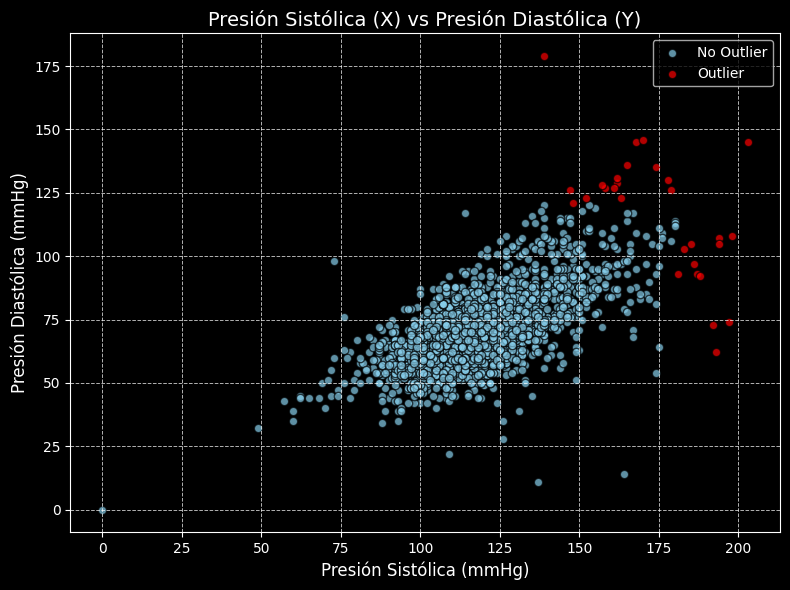

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    df_train.loc[
        ~df_train["Systolic_Outlier"] & ~df_train["Diastolic_Outlier"], "Physical-Systolic_BP"
    ],
    df_train.loc[
        ~df_train["Systolic_Outlier"] & ~df_train["Diastolic_Outlier"], "Physical-Diastolic_BP"
    ],
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
    label="No Outlier",
)

ax.scatter(
    df_train.loc[
        df_train["Systolic_Outlier"] | df_train["Diastolic_Outlier"], "Physical-Systolic_BP"
    ],
    df_train.loc[
        df_train["Systolic_Outlier"] | df_train["Diastolic_Outlier"], "Physical-Diastolic_BP"
    ],
    alpha=0.7,
    color="red",
    edgecolor="black",
    label="Outlier",
)

ax.set_title("Presión Sistólica (X) vs Presión Diastólica (Y)", fontsize=14)
ax.set_xlabel("Presión Sistólica (mmHg)", fontsize=12)
ax.set_ylabel("Presión Diastólica (mmHg)", fontsize=12)
ax.grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


#### Distribución del BMI

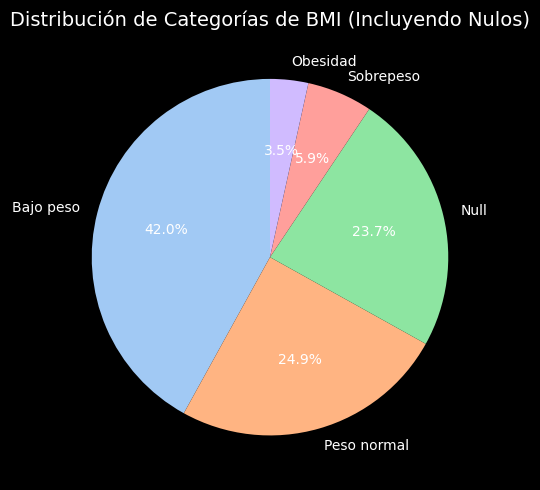

In [ ]:
def classify_bmi(bmi):
    if np.isnan(bmi):
        return "Null"
    if bmi < 18.5:
        return "Bajo peso"
    if 18.5 <= bmi < 24.9:
        return "Peso normal"
    if 25 <= bmi < 29.9:
        return "Sobrepeso"
    return "Obesidad"


df_train["BMI_Category"] = df_train["Physical-BMI"].apply(classify_bmi)

bmi_category_counts = df_train["BMI_Category"].value_counts(normalize=True, dropna=False) * 100

fig, ax = plt.subplots(figsize=(7, 5))
ax.pie(
    bmi_category_counts.values.tolist(),
    labels=bmi_category_counts.index.to_list(),
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("pastel"),
)

ax.set_title("Distribución de Categorías de BMI (Incluyendo Nulos)", fontsize=14)

plt.tight_layout()
plt.show()


`NOTA:` Se ha utilizado los siguientes enlaces para sacar los intervalos:  
https://www.ine.es/jaxi/Tabla.htm?path=/t00/mujeres_hombres/tablas_1/l0/&file=d06001.px&L=0  
https://www.who.int/tools/growth-reference-data-for-5to19-years/indicators/bmi-for-age

#### Matriz de correlación de las medidas físicas

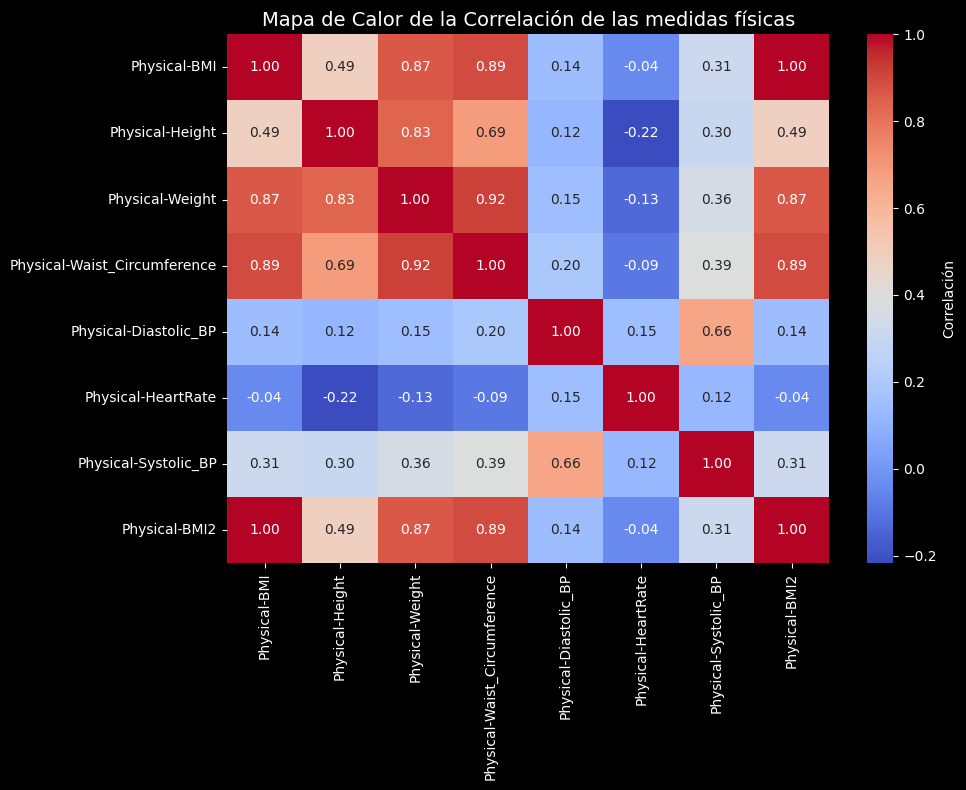

In [454]:
physical_columns = [
    col for col in df_train.columns if col.startswith("Physical") and col != "Physical-Season"
]
correlation_matrix = df_train[physical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Correlación"}
)

plt.title("Mapa de Calor de la Correlación de las medidas físicas", fontsize=14)

plt.tight_layout()
plt.show()


#### Estación del año correspondiente a las medidas físicas

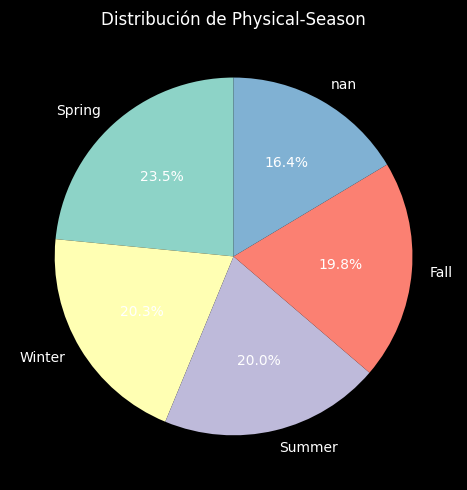

In [ ]:
season_counts = df_train["Physical-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de Physical-Season")

plt.tight_layout()
plt.show()


### `Bio-electric Impedance Analysis`

In [ ]:
columns_to_analyze = [
    col for col in df_train.columns if col.startswith("BIA") and col != "BIA-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                             count         mean          std          min  \
BIA-BIA_Activity_Level_num  1991.0     2.651431     1.028267     1.000000   
BIA-BIA_BMC                 1991.0     6.719826    92.586325    -7.789610   
BIA-BIA_BMI                 1991.0    19.367048     5.047848     0.048267   
BIA-BIA_BMR                 1991.0  1237.018187  1872.383246   813.397000   
BIA-BIA_DEE                 1991.0  2064.693747  2836.246272  1073.450000   
BIA-BIA_ECW                 1991.0    20.825346    73.266287     1.789450   
BIA-BIA_FFM                 1991.0    74.021708   199.433753    28.900400   
BIA-BIA_FFMI                1991.0    15.030554     5.792505     7.864850   
BIA-BIA_FMI                 1991.0     4.336495     6.356402  -194.163000   
BIA-BIA_Fat                 1991.0    16.855020   199.372119 -8745.080000   
BIA-BIA_Frame_num           1991.0     1.745354     0.680635     1.000000   
BIA-BIA_ICW                 1991.0    33.173380    56.272346    14.489000   

#### Histograma de los atributos BIA

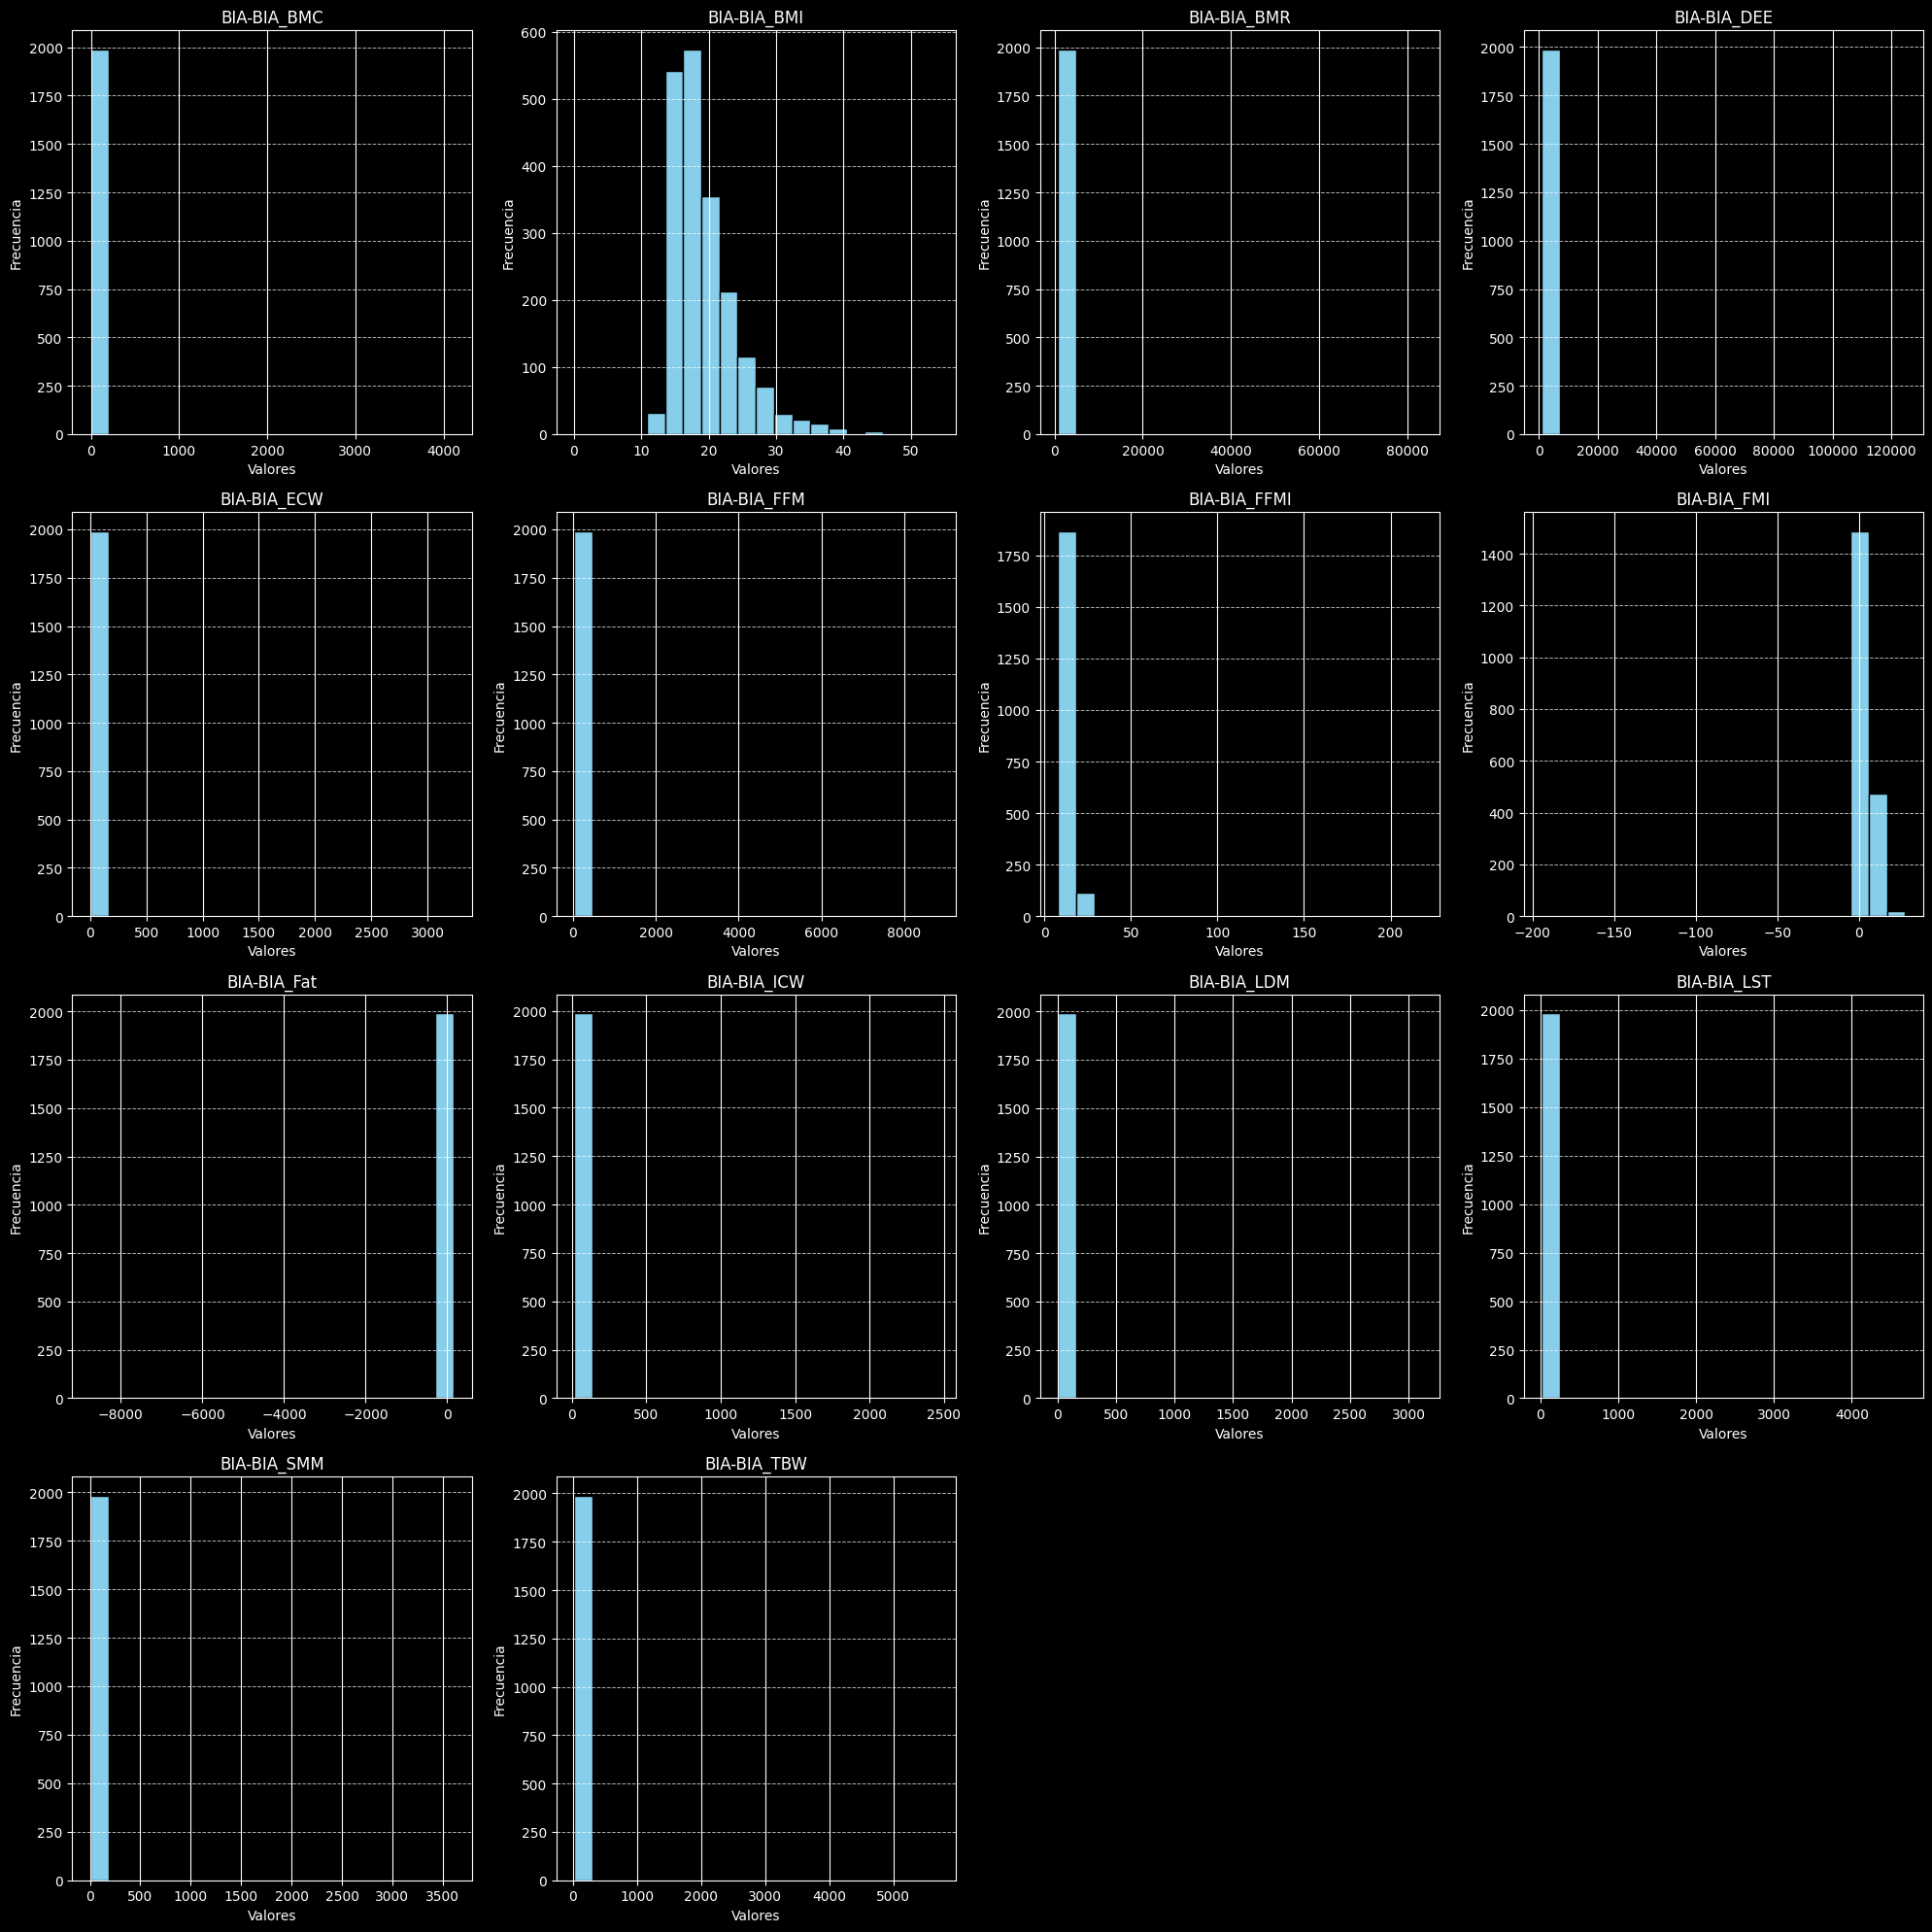

In [ ]:
columns_to_analyze_filtered = [
    col
    for col in columns_to_analyze
    if col not in ["BIA-BIA_Activity_Level_num", "BIA-BIA_Frame_num"]
]

n_cols = 4
n_rows = len(columns_to_analyze_filtered) // n_cols + (
    len(columns_to_analyze_filtered) % n_cols > 0
)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

axes = axes.flatten()

for i, col in enumerate(columns_to_analyze_filtered):
    ax = axes[i]
    df_train[col].hist(bins=20, ax=ax, color="skyblue", edgecolor="black")
    ax.set_title(col, fontsize=12)
    ax.set_xlabel("Valores", fontsize=10)
    ax.set_ylabel("Frecuencia", fontsize=10)
    ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

for j in range(len(columns_to_analyze_filtered), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### Frecuencia en niveles de actividad y tipos de frame

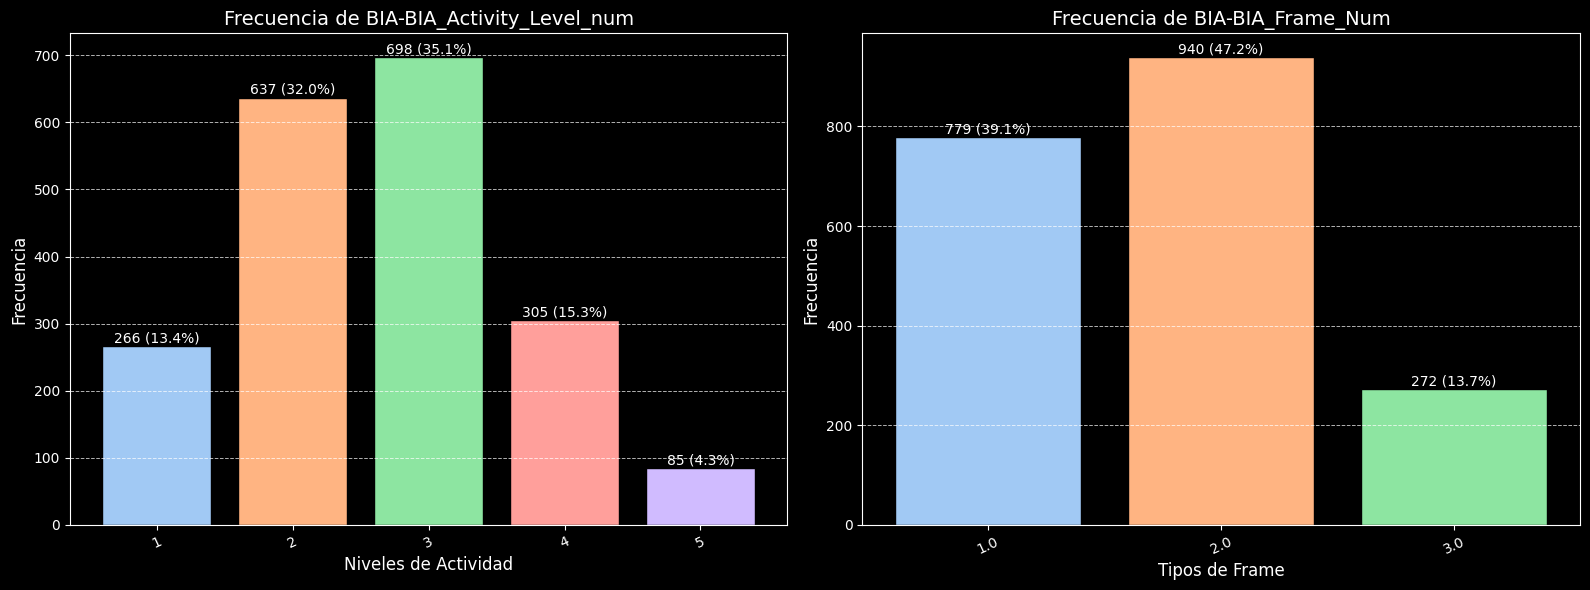

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors_activity = sns.color_palette(
    "pastel", len(df_train["BIA-BIA_Activity_Level_num"].value_counts())
)
colors_frame = sns.color_palette("pastel", len(df_train["BIA-BIA_Frame_num"].value_counts()))

activity_counts = df_train["BIA-BIA_Activity_Level_num"].value_counts(normalize=False).sort_index()
activity_percentages = (
    df_train["BIA-BIA_Activity_Level_num"].value_counts(normalize=True).sort_index() * 100
)

bars = axes[0].bar(
    activity_counts.index, activity_counts.values, color=colors_activity, edgecolor="black"
)
axes[0].set_title("Frecuencia de BIA-BIA_Activity_Level_num", fontsize=14)
axes[0].set_xlabel("Niveles de Actividad", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

for bar, count, percent in zip(bars, activity_counts.values, activity_percentages):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{int(count)} ({percent:.1f}%)",
        ha="center",
        va="bottom",
    )

axes[0].tick_params(axis="x", rotation=25)

frame_counts = df_train["BIA-BIA_Frame_num"].value_counts(normalize=False).sort_index()
frame_percentages = df_train["BIA-BIA_Frame_num"].value_counts(normalize=True).sort_index() * 100

bars = axes[1].bar(
    frame_counts.index.astype(str), frame_counts.values, color=colors_frame, edgecolor="black"
)
axes[1].set_title("Frecuencia de BIA-BIA_Frame_Num", fontsize=14)
axes[1].set_xlabel("Tipos de Frame", fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

for bar, count, percent in zip(bars, frame_counts.values, frame_percentages):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{int(count)} ({percent:.1f}%)",
        ha="center",
        va="bottom",
    )

axes[1].tick_params(axis="x", rotation=25)

plt.tight_layout()
plt.show()


#### Comparación entre BIA-BMI y Physical-BMI

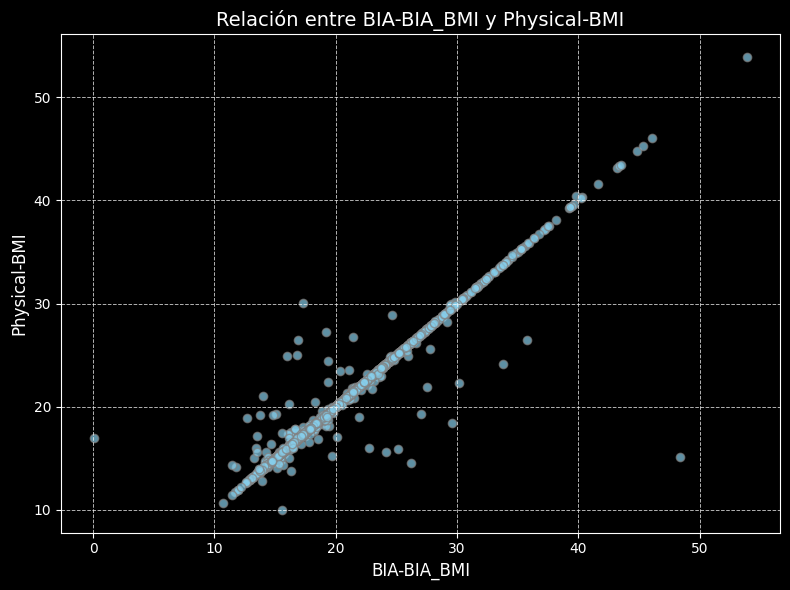

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(
    df_train["BIA-BIA_BMI"], df_train["Physical-BMI"], alpha=0.7, color="skyblue", edgecolor="grey"
)
plt.title("Relación entre BIA-BIA_BMI y Physical-BMI", fontsize=14)
plt.xlabel("BIA-BIA_BMI", fontsize=12)
plt.ylabel("Physical-BMI", fontsize=12)
plt.grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Estación del año correspondiente a las medidas de BIA

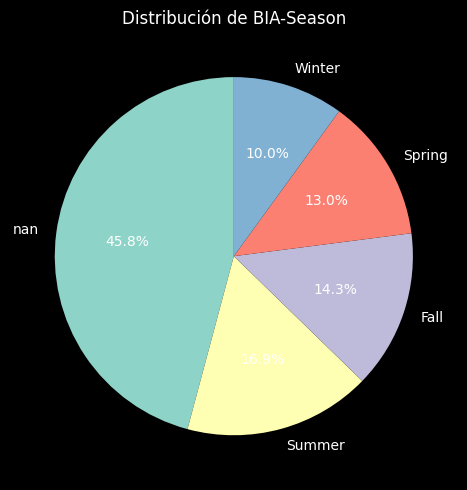

In [ ]:
season_counts = df_train["BIA-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de BIA-Season")

plt.tight_layout()
plt.show()


### `FitnessGram Vitals and Treadmill`

In [461]:
columns_to_analyze = [
    col
    for col in df_train.columns
    if col.startswith("Fitness_Endurance") and col != "Fitness_Endurance-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                             count       mean        std  min    25%   50%  \
Fitness_Endurance-Max_Stage  743.0   4.989233   2.014072  0.0   4.00   5.0   
Fitness_Endurance-Time_Mins  740.0   7.370270   3.189662  0.0   6.00   7.0   
Fitness_Endurance-Time_Sec   740.0  27.581081  17.707751  0.0  12.75  28.0   

                              75%   max   nulls  
Fitness_Endurance-Max_Stage   6.0  28.0  3217.0  
Fitness_Endurance-Time_Mins   9.0  20.0  3220.0  
Fitness_Endurance-Time_Sec   43.0  59.0  3220.0  


#### Histogramas del tiempo en minutos y segundos separados

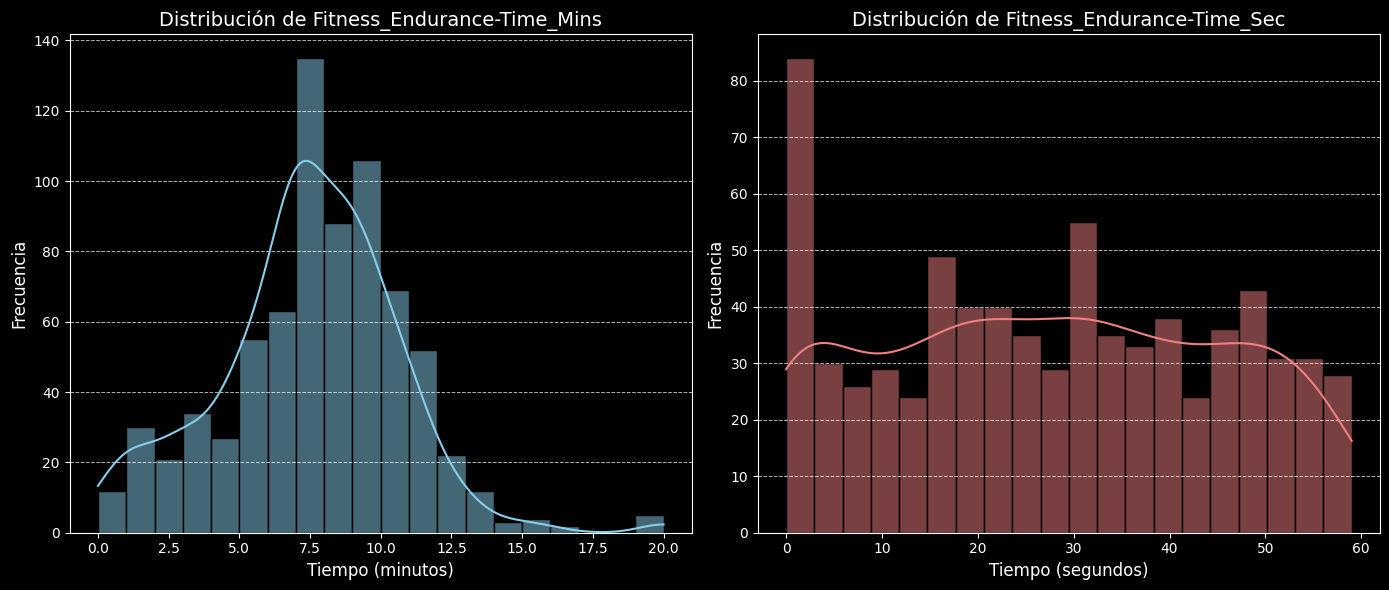

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    data=df_train,
    x="Fitness_Endurance-Time_Mins",
    kde=True,
    ax=axes[0],
    color="skyblue",
    bins=20,
    edgecolor="black",
)
axes[0].set_title("Distribución de Fitness_Endurance-Time_Mins", fontsize=14)
axes[0].set_xlabel("Tiempo (minutos)", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.histplot(
    data=df_train,
    x="Fitness_Endurance-Time_Sec",
    kde=True,
    ax=axes[1],
    color="lightcoral",
    bins=20,
    edgecolor="black",
)
axes[1].set_title("Distribución de Fitness_Endurance-Time_Sec", fontsize=14)
axes[1].set_xlabel("Tiempo (segundos)", fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Dsttibución de los Stage por temporadas

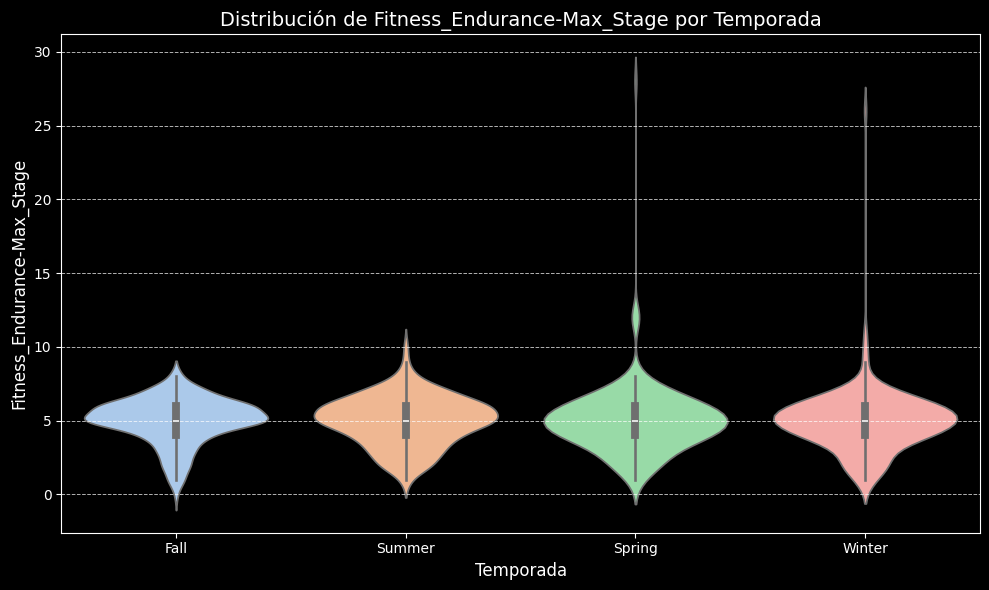

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_train,
    x="Fitness_Endurance-Season",
    hue="Fitness_Endurance-Season",
    legend=False,
    y="Fitness_Endurance-Max_Stage",
    palette="pastel",
)

plt.title("Distribución de Fitness_Endurance-Max_Stage por Temporada", fontsize=14)
plt.xlabel("Temporada", fontsize=12)
plt.ylabel("Fitness_Endurance-Max_Stage", fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Distribución de los stage por las edades

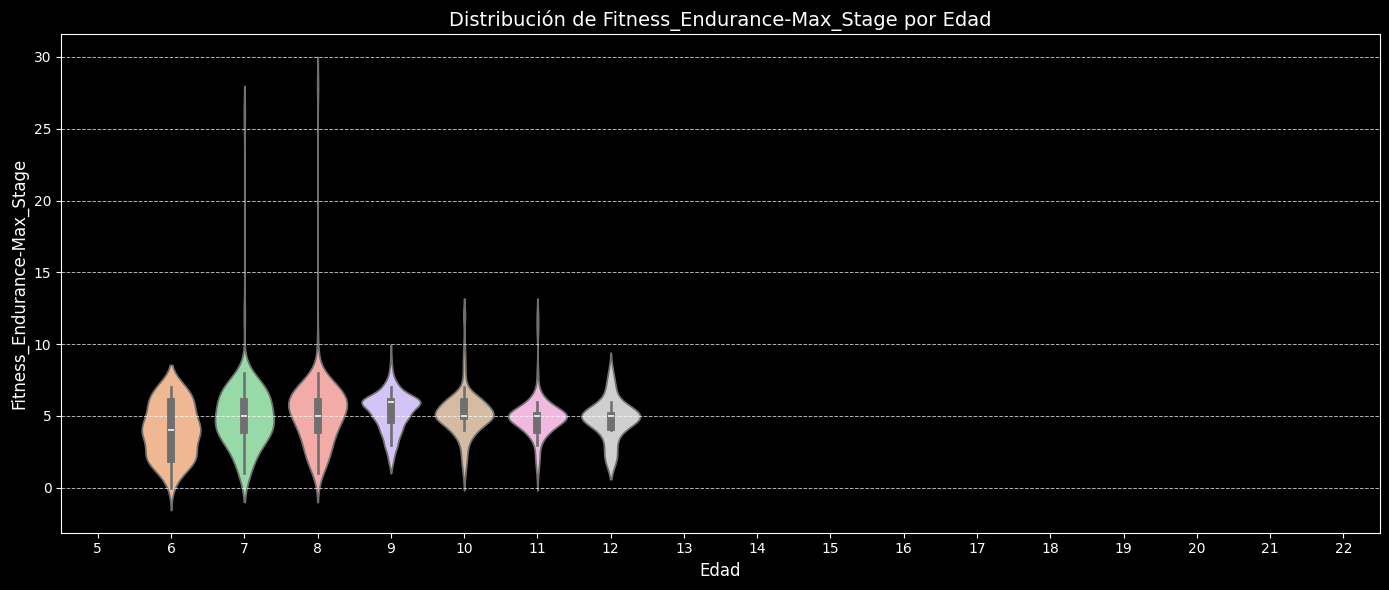

In [ ]:
plt.figure(figsize=(14, 6))
sns.violinplot(
    data=df_train,
    x="Basic_Demos-Age",
    hue="Basic_Demos-Age",
    y="Fitness_Endurance-Max_Stage",
    palette="pastel",
    legend=False,
)

plt.title("Distribución de Fitness_Endurance-Max_Stage por Edad", fontsize=14)
plt.xlabel("Edad", fontsize=12)
plt.ylabel("Fitness_Endurance-Max_Stage", fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Histograma de minutos y segundos combinados

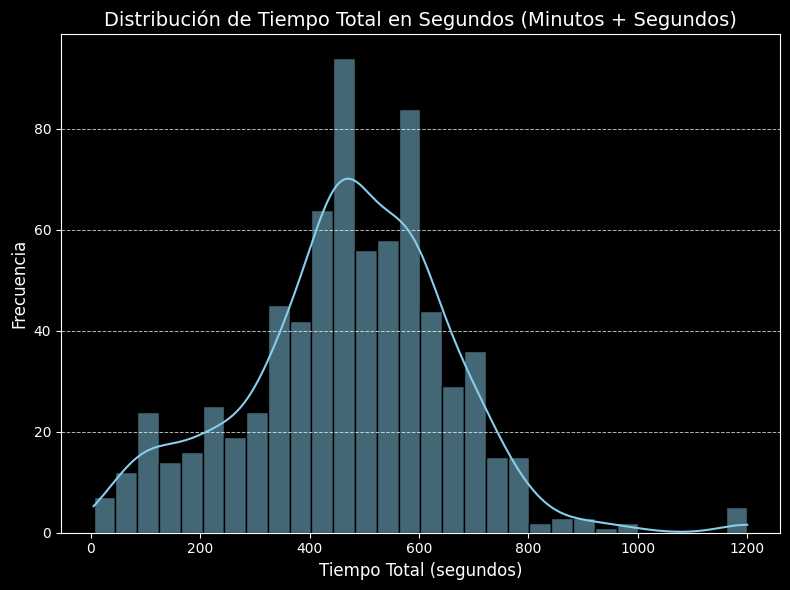

In [465]:
df_train["Fitness_Endurance-Total_Seconds"] = (
    df_train["Fitness_Endurance-Time_Mins"] * 60 + df_train["Fitness_Endurance-Time_Sec"]
)

plt.figure(figsize=(8, 6))
sns.histplot(
    df_train,
    x="Fitness_Endurance-Total_Seconds",
    kde=True,
    bins=30,
    color="skyblue",
    edgecolor="black",
)

plt.title("Distribución de Tiempo Total en Segundos (Minutos + Segundos)", fontsize=14)
plt.xlabel("Tiempo Total (segundos)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Estación del año correspondiente a las medidas de Fitness_Endurance

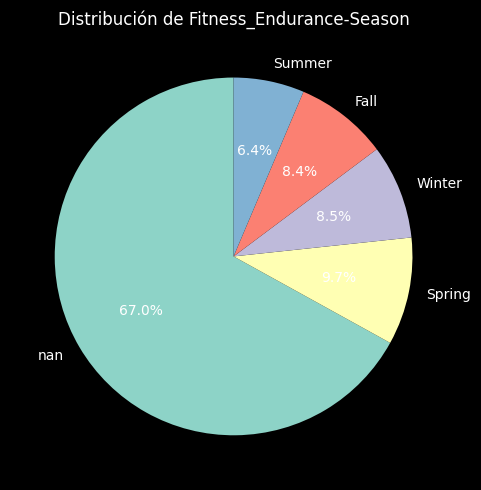

In [ ]:
season_counts = (
    df_train["Fitness_Endurance-Season"].value_counts(normalize=True, dropna=False) * 100
)

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de Fitness_Endurance-Season")

plt.tight_layout()
plt.show()


### `FitnessGram Child`

In [467]:
columns_to_analyze = [
    col for col in df_train.columns if col.startswith("FGC") and col != "FGC-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                    count       mean        std  min   25%    50%     75%  \
FGC-FGC_CU         2322.0  11.259690  11.807781  0.0   3.0   9.00  15.750   
FGC-FGC_CU_Zone    2282.0   0.476337   0.499549  0.0   0.0   0.00   1.000   
FGC-FGC_GSND       1074.0  22.420438  10.833995  0.0  15.1  20.05  26.600   
FGC-FGC_GSND_Zone  1062.0   1.829567   0.612585  1.0   1.0   2.00   2.000   
FGC-FGC_GSD        1074.0  23.518622  11.148951  0.0  16.2  21.20  28.175   
FGC-FGC_GSD_Zone   1063.0   1.904045   0.612344  1.0   2.0   2.00   2.000   
FGC-FGC_PU         2310.0   5.579654   7.390161  0.0   0.0   3.00   9.000   
FGC-FGC_PU_Zone    2271.0   0.330251   0.470407  0.0   0.0   0.00   1.000   
FGC-FGC_SRL        2305.0   8.694924   3.429301  0.0   7.0   9.00  11.000   
FGC-FGC_SRL_Zone   2267.0   0.618880   0.485769  0.0   0.0   1.00   1.000   
FGC-FGC_SRR        2307.0   8.805635   3.422167  0.0   7.0   9.00  11.000   
FGC-FGC_SRR_Zone   2269.0   0.620097   0.485469  0.0   0.0   1.00   1.000   

#### Histogramas de los atributos de FGC

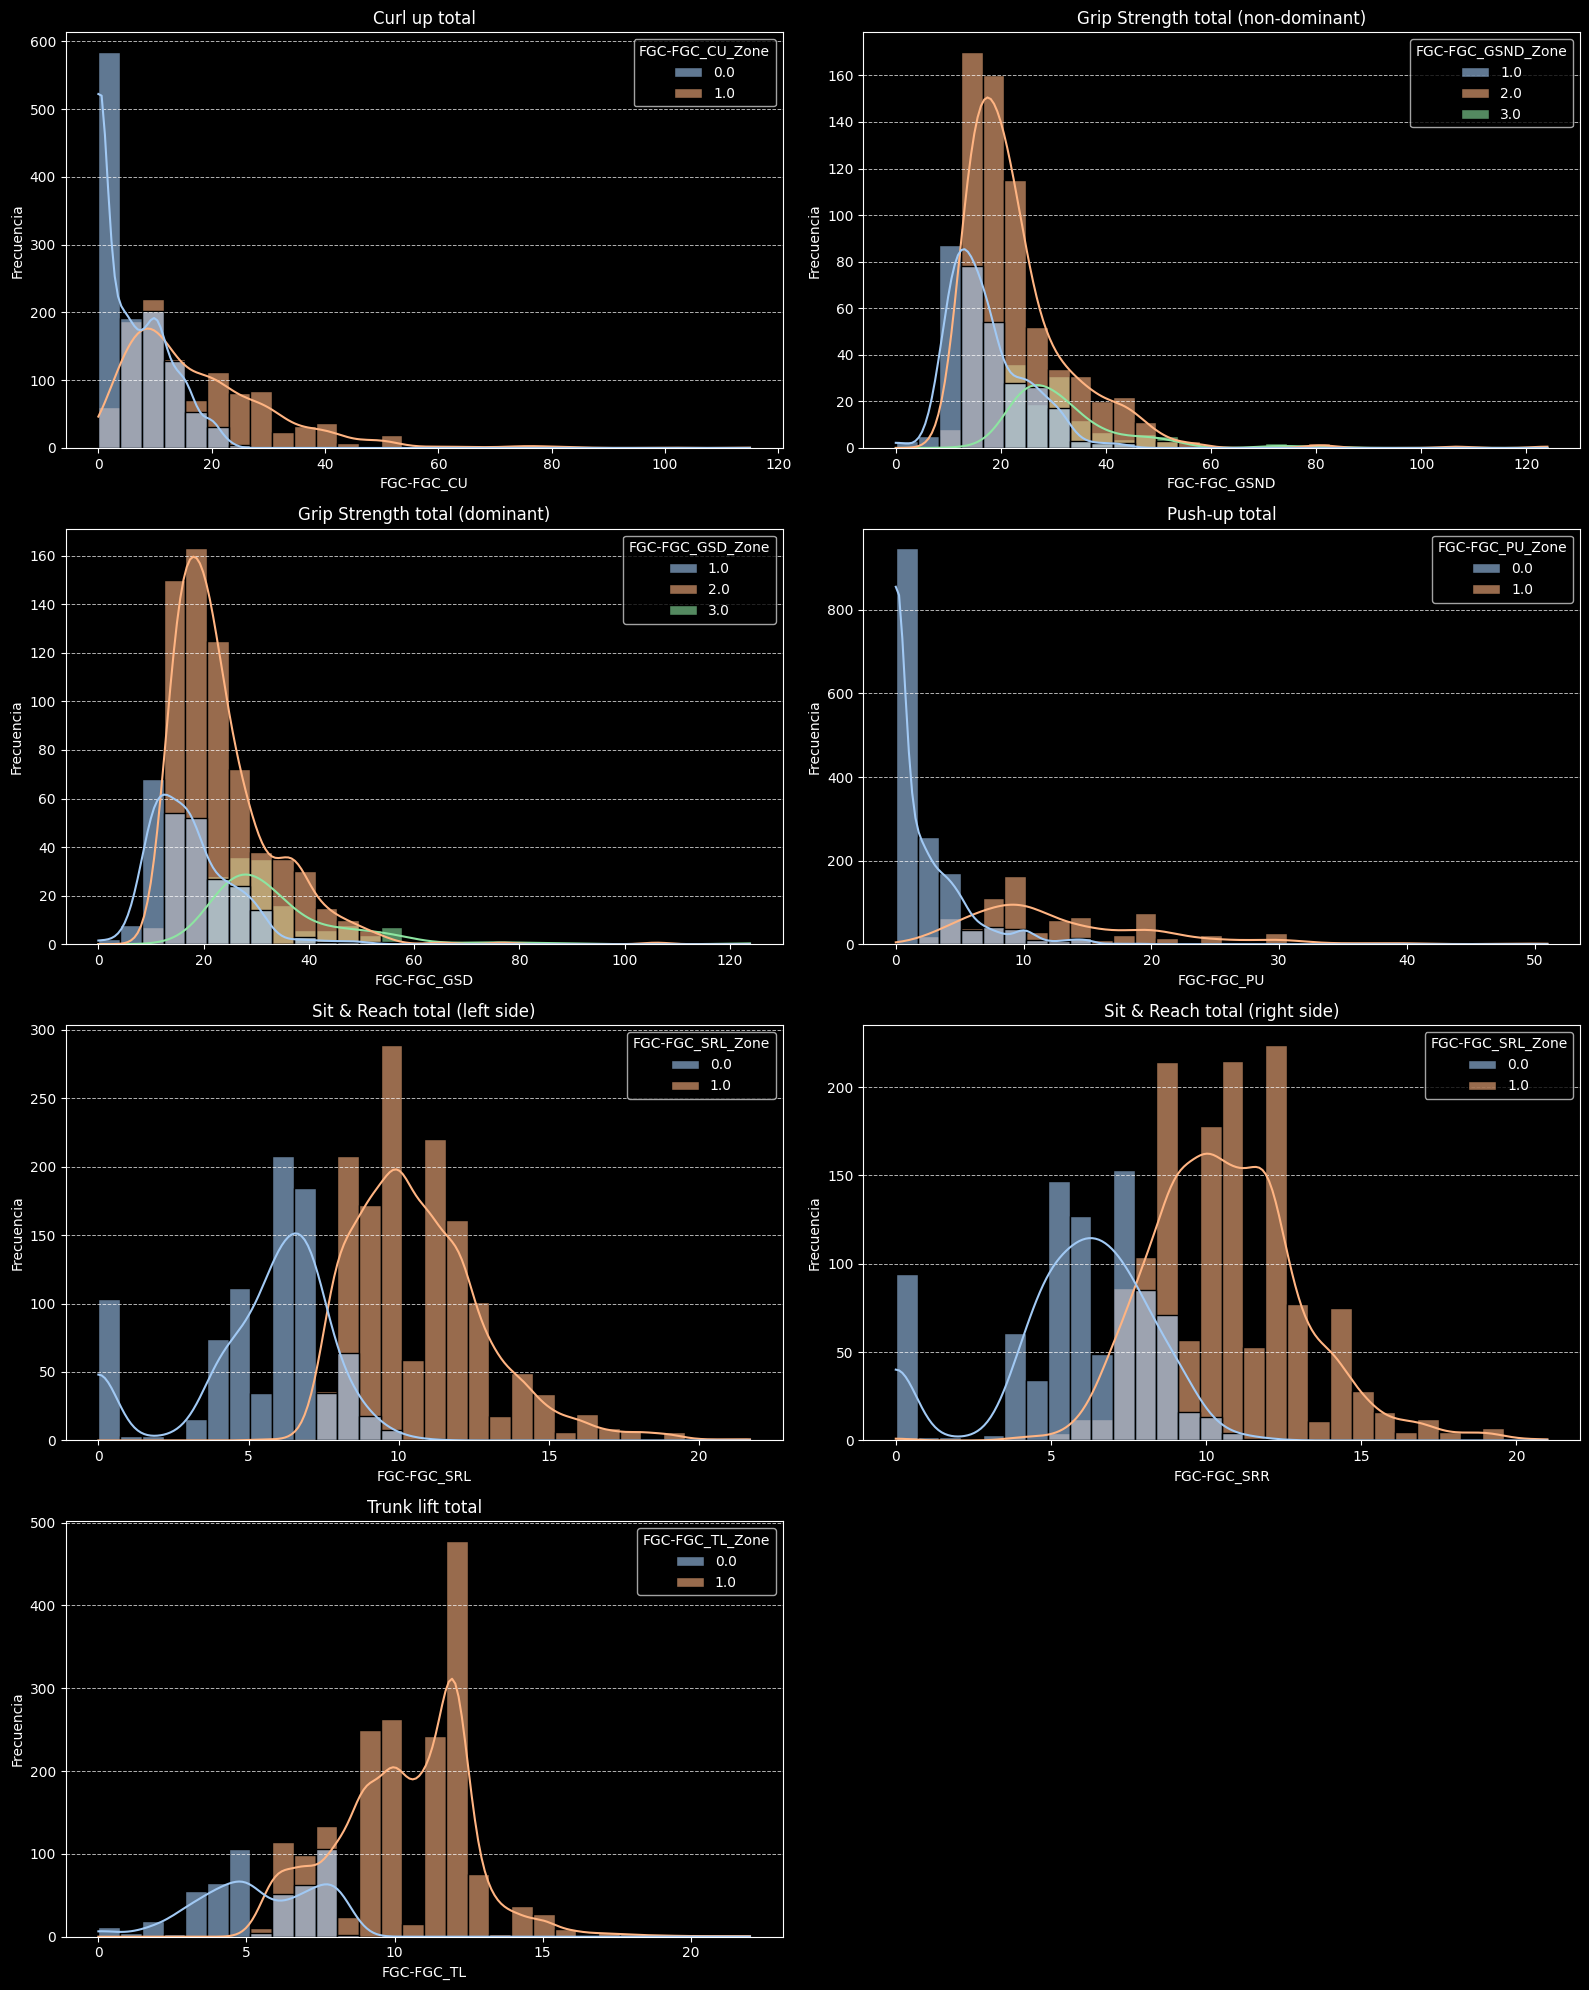

In [ ]:
column_pairs = [
    ("FGC-FGC_CU", "FGC-FGC_CU_Zone"),
    ("FGC-FGC_GSND", "FGC-FGC_GSND_Zone"),
    ("FGC-FGC_GSD", "FGC-FGC_GSD_Zone"),
    ("FGC-FGC_PU", "FGC-FGC_PU_Zone"),
    ("FGC-FGC_SRL", "FGC-FGC_SRL_Zone"),
    ("FGC-FGC_SRR", "FGC-FGC_SRL_Zone"),
    ("FGC-FGC_TL", "FGC-FGC_TL_Zone"),
]

n_cols = 2
n_rows = len(column_pairs) // n_cols + (len(column_pairs) % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, (x_col, hue_col) in enumerate(column_pairs):
    sns.histplot(
        data=df_train,
        x=x_col,
        hue=hue_col,
        kde=True,
        multiple="layer",
        alpha=0.6,
        bins=30,
        palette="pastel",
        edgecolor="black",
        ax=axes[i],
    )

    description = df_dictionary.loc[df_dictionary["Field"] == x_col, "Description"].values
    title = description[0] if len(description) > 0 else f"Distribución de {x_col} por {hue_col}"

    axes[i].set_title(title, fontsize=12)
    axes[i].set_xlabel(x_col, fontsize=10)
    axes[i].set_ylabel("Frecuencia", fontsize=10)
    axes[i].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

for j in range(len(column_pairs), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


#### Comparación extremidad dominante vs no dominante

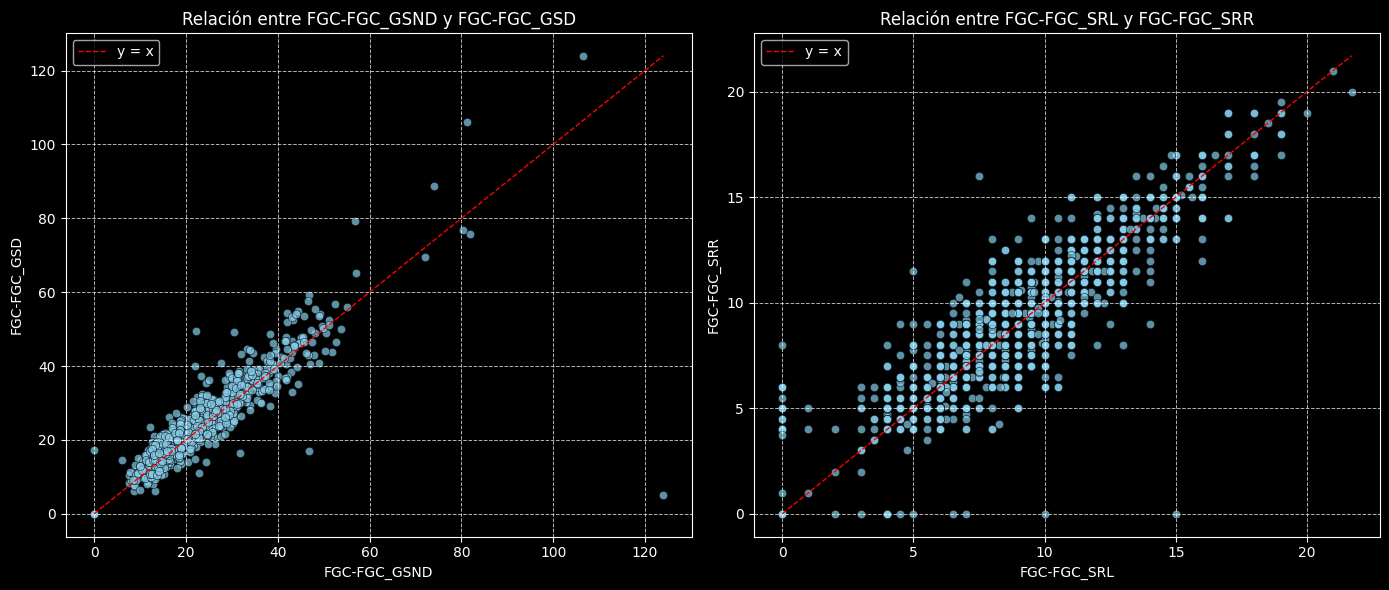

In [ ]:
scatter_pairs = [("FGC-FGC_GSND", "FGC-FGC_GSD"), ("FGC-FGC_SRL", "FGC-FGC_SRR")]

fig, axes = plt.subplots(1, len(scatter_pairs), figsize=(14, 6))

for i, (x_col, y_col) in enumerate(scatter_pairs):
    sns.scatterplot(
        data=df_train, x=x_col, y=y_col, alpha=0.7, color="skyblue", edgecolor="black", ax=axes[i]
    )

    axes[i].set_title(f"Relación entre {x_col} y {y_col}", fontsize=12)
    axes[i].set_xlabel(x_col, fontsize=10)
    axes[i].set_ylabel(y_col, fontsize=10)
    axes[i].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)

    min_val = min(df_train[x_col].min(), df_train[y_col].min())
    max_val = max(df_train[x_col].max(), df_train[y_col].max())
    axes[i].plot(
        [min_val, max_val],
        [min_val, max_val],
        color="red",
        linestyle="--",
        linewidth=1,
        label="y = x",
    )
    axes[i].legend()

plt.tight_layout()
plt.show()


#### Correlaciones entre los atributos de FGC

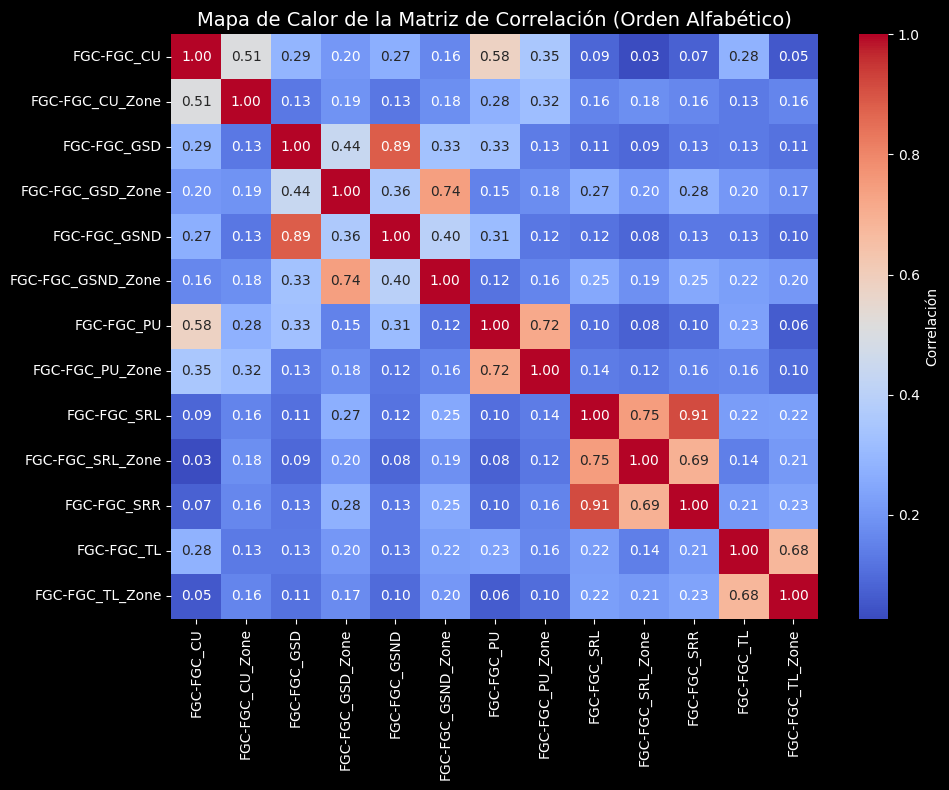

In [ ]:
all_columns = sorted(list(set([col for pair in column_pairs for col in pair])))

correlation_matrix = df_train[all_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Correlación"}
)

plt.title("Mapa de Calor de la Matriz de Correlación (Orden Alfabético)", fontsize=14)

plt.tight_layout()
plt.show()


#### Estación del año correspondiente a las medidas de FGC

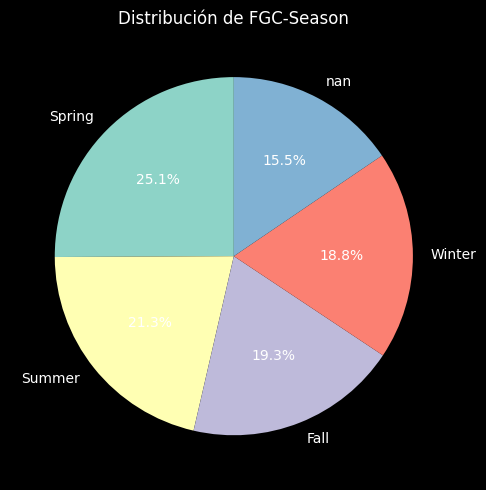

In [ ]:
season_counts = df_train["FGC-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de FGC-Season")

plt.tight_layout()
plt.show()


### `Sleep Disturbance Scale(SDS)`

In [472]:
columns_to_analyze = [
    col for col in df_train.columns if col.startswith("SDS") and col != "SDS-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                    count       mean        std   min   25%   50%   75%  \
SDS-SDS_Total_Raw  2609.0  41.088923  10.427433  17.0  33.0  39.0  46.0   
SDS-SDS_Total_T    2606.0  57.763622  13.196091  38.0  47.0  55.0  64.0   

                     max   nulls  
SDS-SDS_Total_Raw   96.0  1351.0  
SDS-SDS_Total_T    100.0  1354.0  


#### Histograma de ambas puntuaciones de SDS

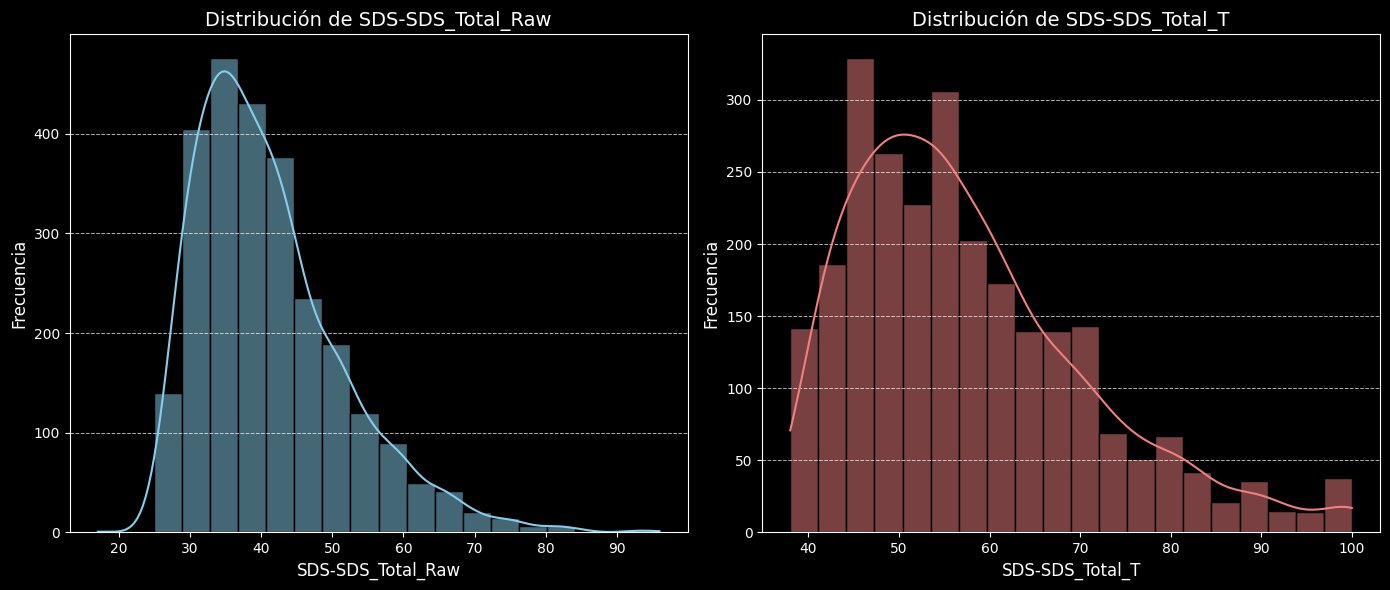

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    data=df_train,
    x=columns_to_analyze[0],
    kde=True,
    bins=20,
    color="skyblue",
    edgecolor="black",
    ax=axes[0],
)
axes[0].set_title(f"Distribución de {columns_to_analyze[0]}", fontsize=14)
axes[0].set_xlabel(columns_to_analyze[0], fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.histplot(
    data=df_train,
    x=columns_to_analyze[1],
    kde=True,
    bins=20,
    color="lightcoral",
    edgecolor="black",
    ax=axes[1],
)
axes[1].set_title(f"Distribución de {columns_to_analyze[1]}", fontsize=14)
axes[1].set_xlabel(columns_to_analyze[1], fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Comparación puntuación total y raw

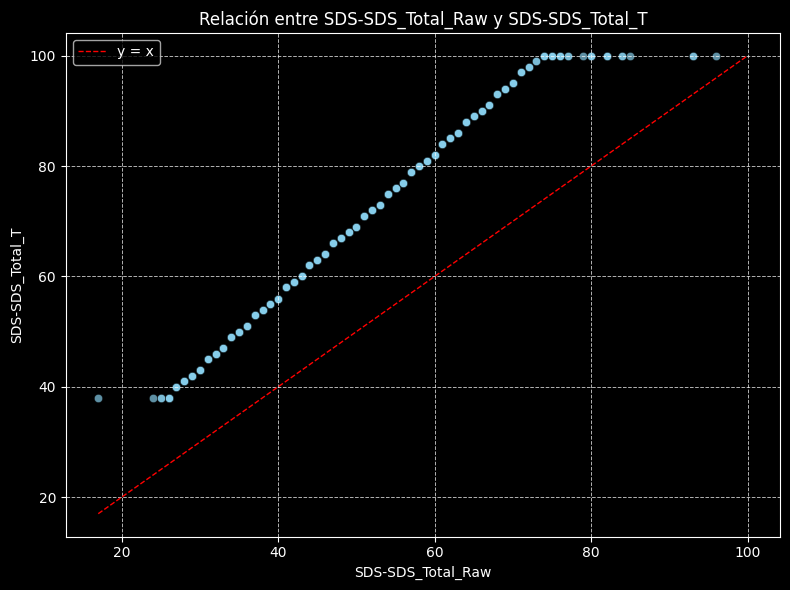

In [ ]:
scatter_pairs = [(columns_to_analyze[0], columns_to_analyze[1])]

fig, axes = plt.subplots(1, len(scatter_pairs), figsize=(8, 6))

if len(scatter_pairs) == 1:
    axes = [axes]

for i, (x_col, y_col) in enumerate(scatter_pairs):
    sns.scatterplot(
        data=df_train, x=x_col, y=y_col, alpha=0.7, color="skyblue", edgecolor="black", ax=axes[i]
    )

    axes[i].set_title(f"Relación entre {x_col} y {y_col}", fontsize=12)
    axes[i].set_xlabel(x_col, fontsize=10)
    axes[i].set_ylabel(y_col, fontsize=10)
    axes[i].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)

    min_val = min(df_train[x_col].min(), df_train[y_col].min())
    max_val = max(df_train[x_col].max(), df_train[y_col].max())
    axes[i].plot(
        [min_val, max_val],
        [min_val, max_val],
        color="red",
        linestyle="--",
        linewidth=1,
        label="y = x",
    )
    axes[i].legend()

plt.tight_layout()
plt.show()


#### Estación del año correspondiente a las medidas de SDS

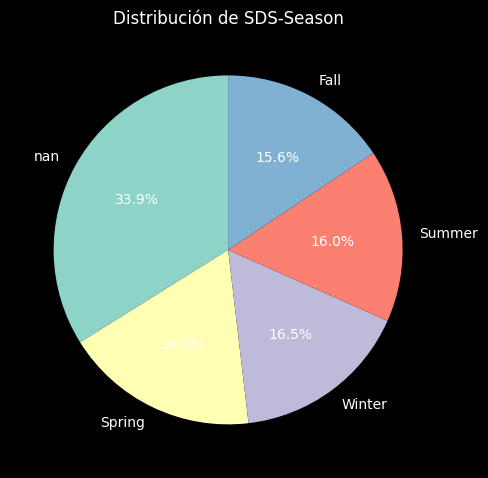

In [ ]:
season_counts = df_train["SDS-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de SDS-Season")

plt.tight_layout()
plt.show()


### `Physical Activity Questionnaire(PAQ)`

In [476]:
columns_to_analyze = [
    col
    for col in df_train.columns
    if col.startswith("PAQ") and col != "PAQ_A-Season" and col != "PAQ_C-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                    count      mean       std   min   25%   50%   75%   max  \
PAQ_A-PAQ_A_Total   475.0  2.178853  0.849476  0.66  1.49  2.01  2.78  4.71   
PAQ_C-PAQ_C_Total  1721.0  2.589550  0.783937  0.58  2.02  2.54  3.16  4.79   

                    nulls  
PAQ_A-PAQ_A_Total  3485.0  
PAQ_C-PAQ_C_Total  2239.0  


#### Histograma + Distribución de puntuaciones de adolesentes

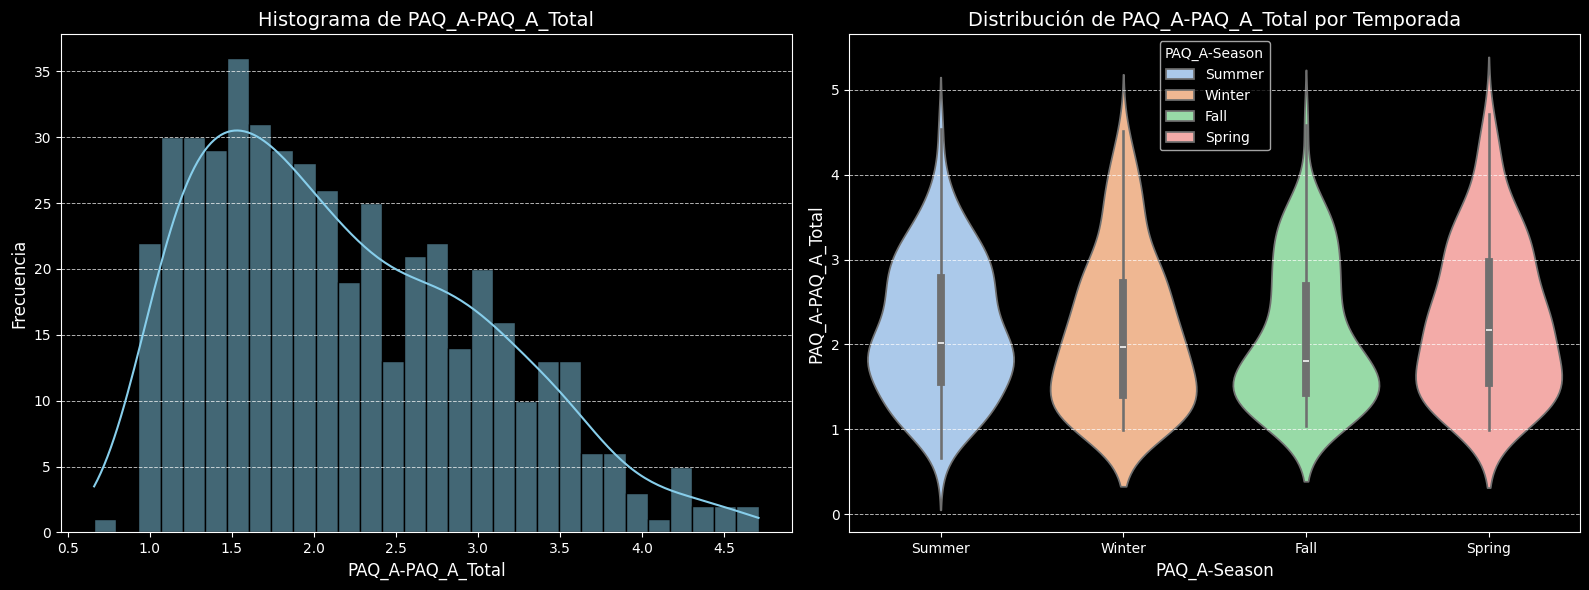

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(
    data=df_train,
    x="PAQ_A-PAQ_A_Total",
    kde=True,
    bins=30,
    color="skyblue",
    edgecolor="black",
    ax=axes[0],
)
axes[0].set_title("Histograma de PAQ_A-PAQ_A_Total", fontsize=14)
axes[0].set_xlabel("PAQ_A-PAQ_A_Total", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.violinplot(
    data=df_train,
    x="PAQ_A-Season",
    hue="PAQ_A-Season",
    y="PAQ_A-PAQ_A_Total",
    palette="pastel",
    ax=axes[1],
)
axes[1].set_title("Distribución de PAQ_A-PAQ_A_Total por Temporada", fontsize=14)
axes[1].set_xlabel("PAQ_A-Season", fontsize=12)
axes[1].set_ylabel("PAQ_A-PAQ_A_Total", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Estación del año correspondiente a las medidas de PAQ_A-Season

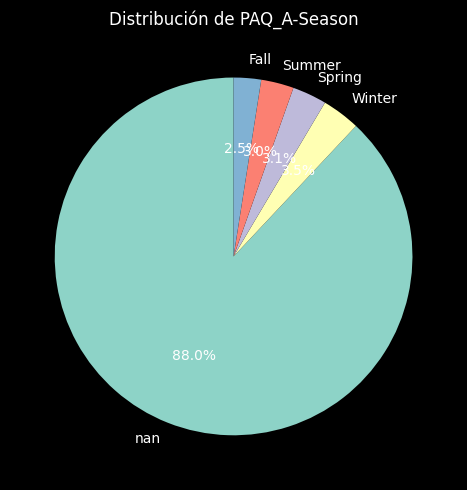

In [ ]:
season_counts = df_train["PAQ_A-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de PAQ_A-Season")

plt.tight_layout()
plt.show()


#### Histograma + Distribución de puntuaciones de niños

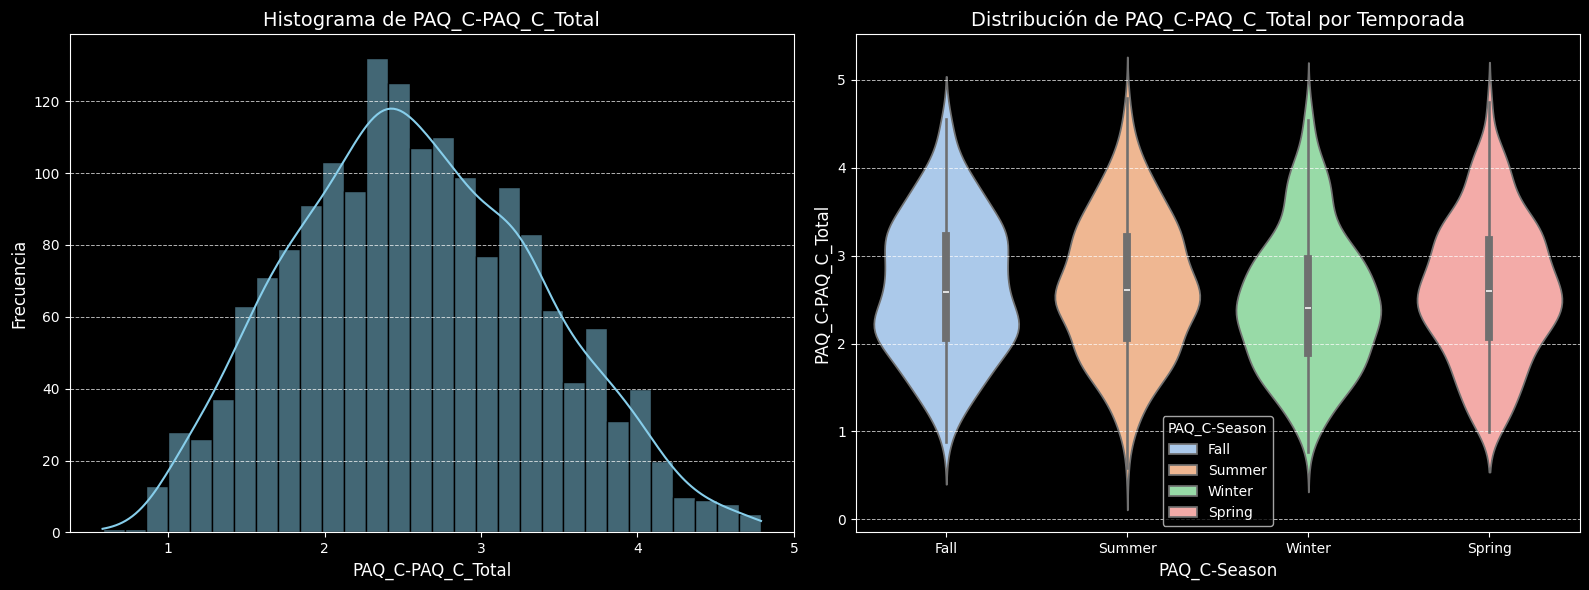

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(
    data=df_train,
    x="PAQ_C-PAQ_C_Total",
    kde=True,
    bins=30,
    color="skyblue",
    edgecolor="black",
    ax=axes[0],
)
axes[0].set_title("Histograma de PAQ_C-PAQ_C_Total", fontsize=14)
axes[0].set_xlabel("PAQ_C-PAQ_C_Total", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.violinplot(
    data=df_train,
    x="PAQ_C-Season",
    hue="PAQ_C-Season",
    y="PAQ_C-PAQ_C_Total",
    palette="pastel",
    ax=axes[1],
)
axes[1].set_title("Distribución de PAQ_C-PAQ_C_Total por Temporada", fontsize=14)
axes[1].set_xlabel("PAQ_C-Season", fontsize=12)
axes[1].set_ylabel("PAQ_C-PAQ_C_Total", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Estación del año correspondiente a las medidas de PAQ_C-Season

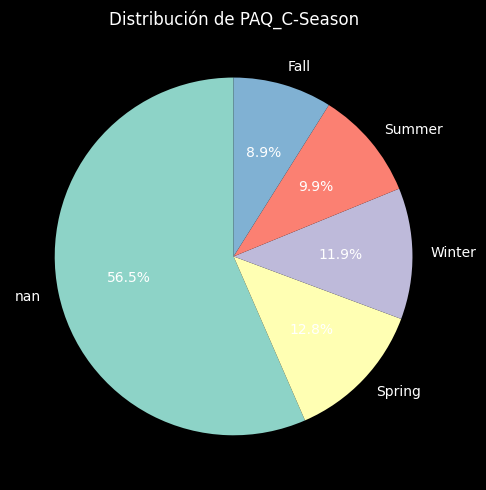

In [ ]:
season_counts = df_train["PAQ_C-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de PAQ_C-Season")

plt.tight_layout()
plt.show()


In [481]:
data = df_train[df_train["PAQ_A-PAQ_A_Total"].notnull()]
age_range = data["Basic_Demos-Age"]
print(
    f"Rango de edad de adolescentes según PAQ_A-PAQ_A_Total: "
    f" {age_range.min()} - {age_range.max()} años"
)


Rango de edad de adolescentes según PAQ_A-PAQ_A_Total:  13 - 18 años


In [482]:
data = df_train[df_train["PAQ_C-PAQ_C_Total"].notnull()]
age_range = data["Basic_Demos-Age"]
print(
    f"Rango de edad de niños según PAQ_C-PAQ_C_Total:  {age_range.min()} - {age_range.max()} años"
)


Rango de edad de niños según PAQ_C-PAQ_C_Total:  7 - 17 años


`NOTA:` Parece que las edades que nos dan estos atributos no están en un rango correcto según los valores anteiormente vistos. 

## Jose Antonio


### Estudio Y


## Santiago


### Distribuciones de las variables

In [483]:
def pciat(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo Physical-BMI
    """
    COLUMNS = "PCIAT-PCIAT_Total"
    # Esta es la excepcion, asumimos que esta correcto y no quitamos "outliers"
    data = [df[COLUMNS] for df in dfs.values()]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("PCIAT-PCIAT_Total")


compare_functions.append(pciat)


def bmi(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo Physical-BMI
    """
    COLUMNS = "Physical-BMI"
    data = [filter_outliers(df, [COLUMNS]) for df in dfs.values()]
    data = [df[COLUMNS] for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("Physical-BMI")


compare_functions.append(bmi)


def fat(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo BIA-BIA_Fat
    """

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    COLUMNS = ["BIA-BIA_FFM", "BIA-BIA_Fat"]
    data = [filter_outliers(df, COLUMNS) for df in dfs.values()]
    data = [compose_values(df[COLUMNS]) for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("Fat %")


compare_functions.append(fat)


def bone(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo BIA-BIA_BMC
    """
    COLUMNS = "BIA-BIA_BMC"
    data = [filter_outliers(df, [COLUMNS]) for df in dfs.values()]
    data = [df[COLUMNS] for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("BMC")


compare_functions.append(bone)


def bpm(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo Physical-HeartRate
    """
    COLUMNS = "Physical-HeartRate"
    data = [filter_outliers(df, [COLUMNS]) for df in dfs.values()]
    data = [df[COLUMNS] for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("Physical-HeartRate")


compare_functions.append(bpm)


def systolic(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo Physical-Systolic_BP
    """
    COLUMNS = "Physical-Systolic_BP"
    data = [filter_outliers(df, [COLUMNS]) for df in dfs.values()]
    data = [df[COLUMNS] for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("Physical-Systolic_BP")


compare_functions.append(systolic)


### Correlaciones entre variables

In [484]:
def bmi_bpm(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-BMI y Phisical-HeartRate
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-BMI", "Physical-HeartRate"])
        ax.scatter(
            data["Physical-BMI"],
            data["Physical-HeartRate"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("Physical-BMI")
    ax.set_ylabel("Physical-HeartRate")
    ax.legend()


compare_functions.append(bmi_bpm)


def bmi_systolic(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-Systolic_BP and BIA-BIA_BMI
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-Systolic_BP", "BIA-BIA_BMI"])
        ax.scatter(
            data["BIA-BIA_BMI"],
            data["Physical-Systolic_BP"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("BIA-BIA_BMI")
    ax.set_ylabel("Physical-Systolic")
    ax.legend()


compare_functions.append(bmi_systolic)


def bmi_fat(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-BMI y BIA-BIA_Fat
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-BMI", "BIA-BIA_Fat", "BIA-BIA_FFM"])
        ax.scatter(
            data["Physical-BMI"],
            compose_values(data),
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("Physical-BMI")
    ax.set_ylabel("BIA-BIA_Fat")
    ax.legend()


compare_functions.append(bmi_fat)


def fat_bpm(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-HeartRate y BIA-BIA_Fat
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-HeartRate", "BIA-BIA_Fat", "BIA-BIA_FFM"])
        ax.scatter(
            compose_values(data),
            data["Physical-HeartRate"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("BIA-BIA_Fat")
    ax.set_ylabel("Physical-HeartRate")
    ax.legend()


compare_functions.append(fat_bpm)


def fat_bone(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos BIA-BIA_BMC y BIA-BIA_Fat
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["BIA-BIA_BMC", "BIA-BIA_Fat", "BIA-BIA_FFM"])
        ax.scatter(
            compose_values(data),
            data["BIA-BIA_BMC"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("BIA-BIA_Fat")
    ax.set_ylabel("BIA-BIA_BMC")
    ax.legend()


compare_functions.append(fat_bone)


def bpm_bone(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos BIA-BIA_BMC y Physical-HeartRate
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-HeartRate", "BIA-BIA_BMC"])
        ax.scatter(
            data["Physical-HeartRate"],
            data["BIA-BIA_BMC"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("Physical-HeartRate")
    ax.set_ylabel("BIA-BIA_BMC")
    ax.legend()


compare_functions.append(bpm_bone)


def bmi_bone(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos BIA-BIA_BMC y Physical-BMI
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-BMI", "BIA-BIA_BMC"])
        ax.scatter(
            data["Physical-BMI"],
            data["BIA-BIA_BMC"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("Physical-BMI")
    ax.set_ylabel("BIA-BIA_BMC")
    ax.legend()


compare_functions.append(bmi_bone)


## Ejecucion de redes


/home/mili/Documentos/Mili-ssm.github.io/Projects/Python/MIOTI_DS_ProyectoFinal/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


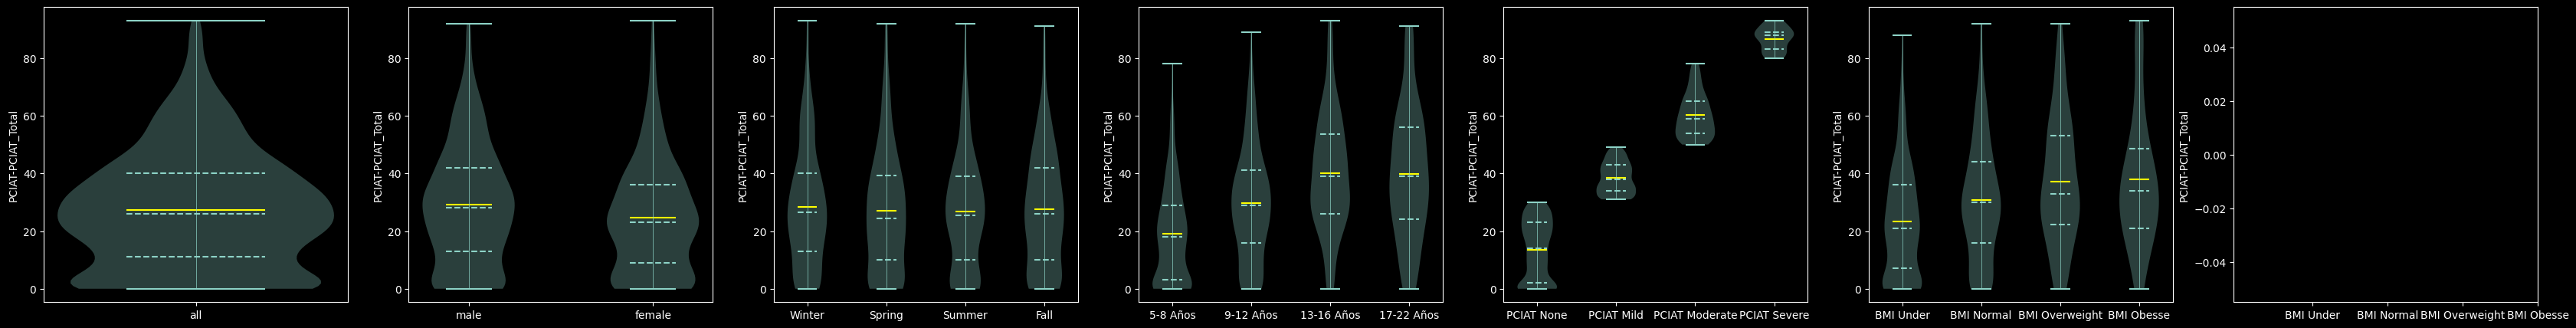

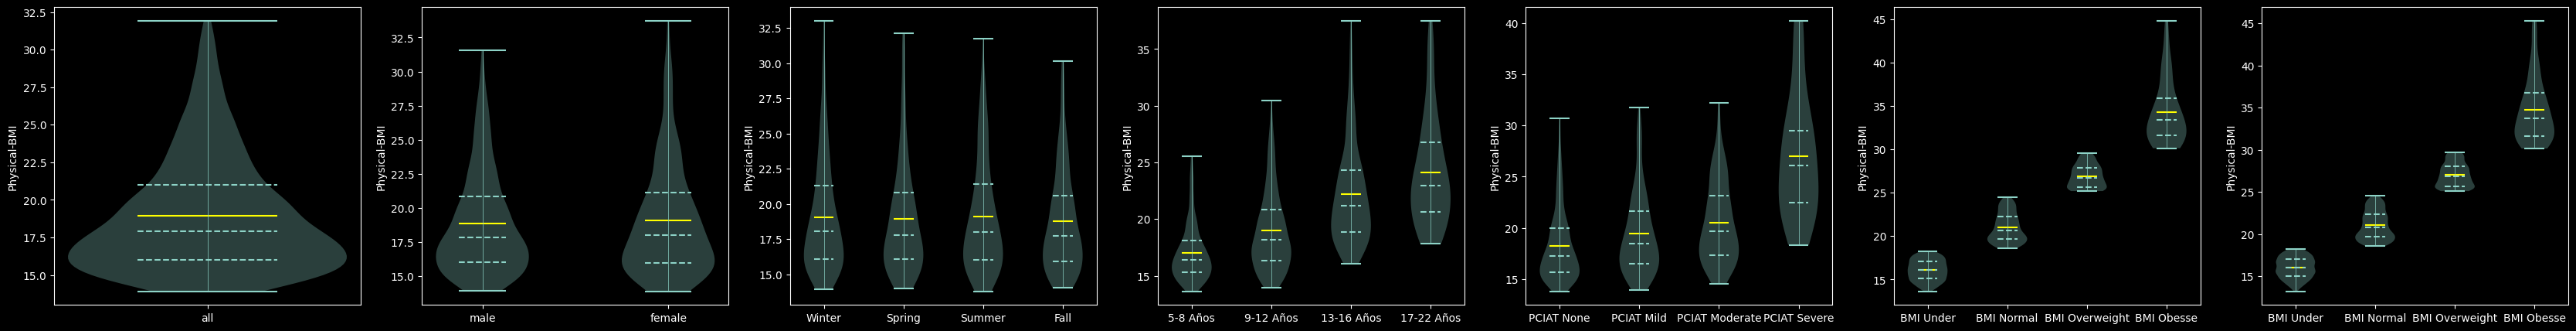

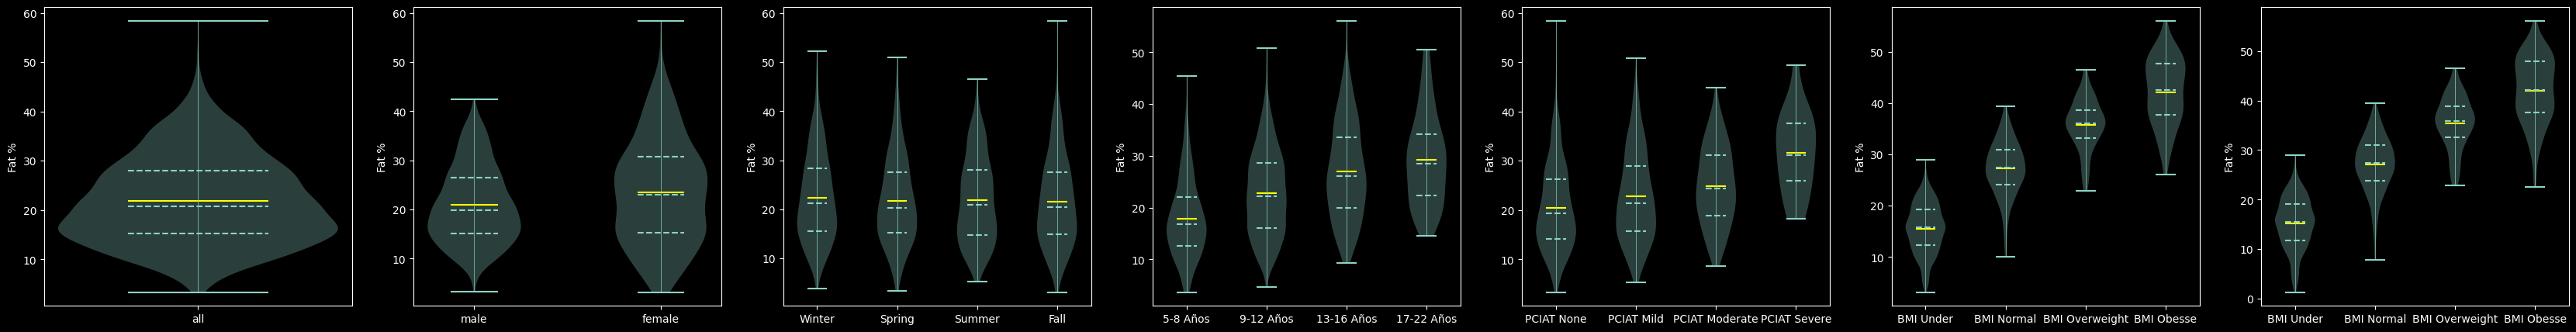

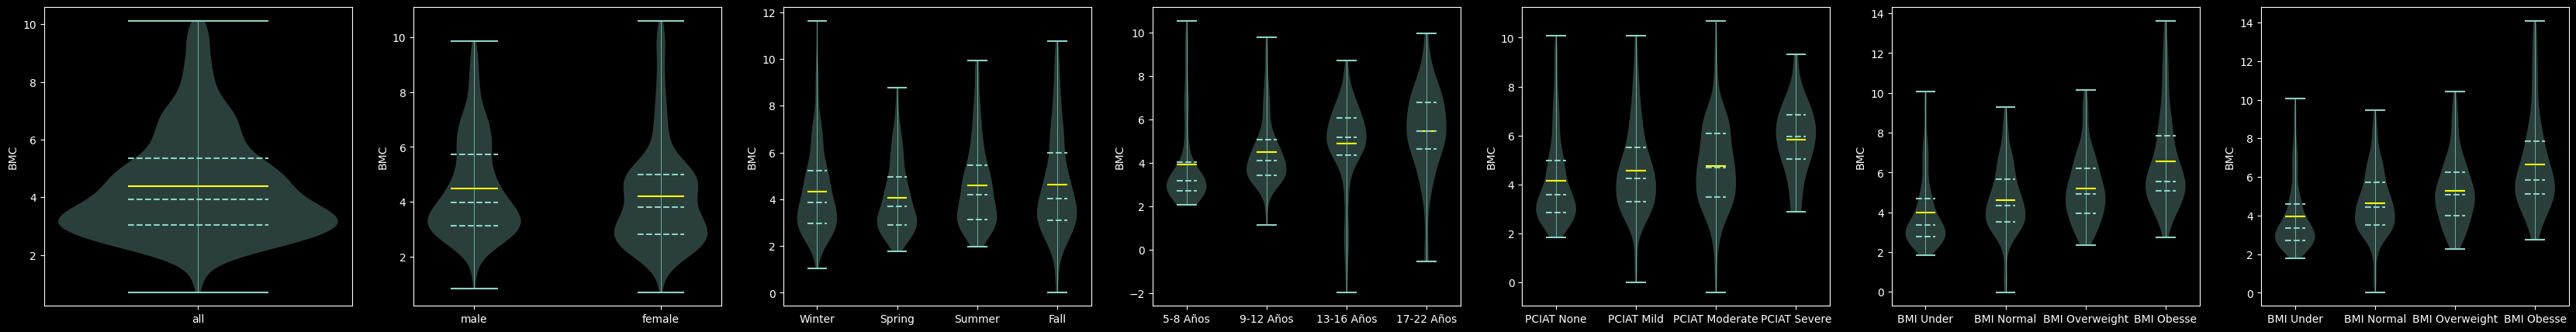

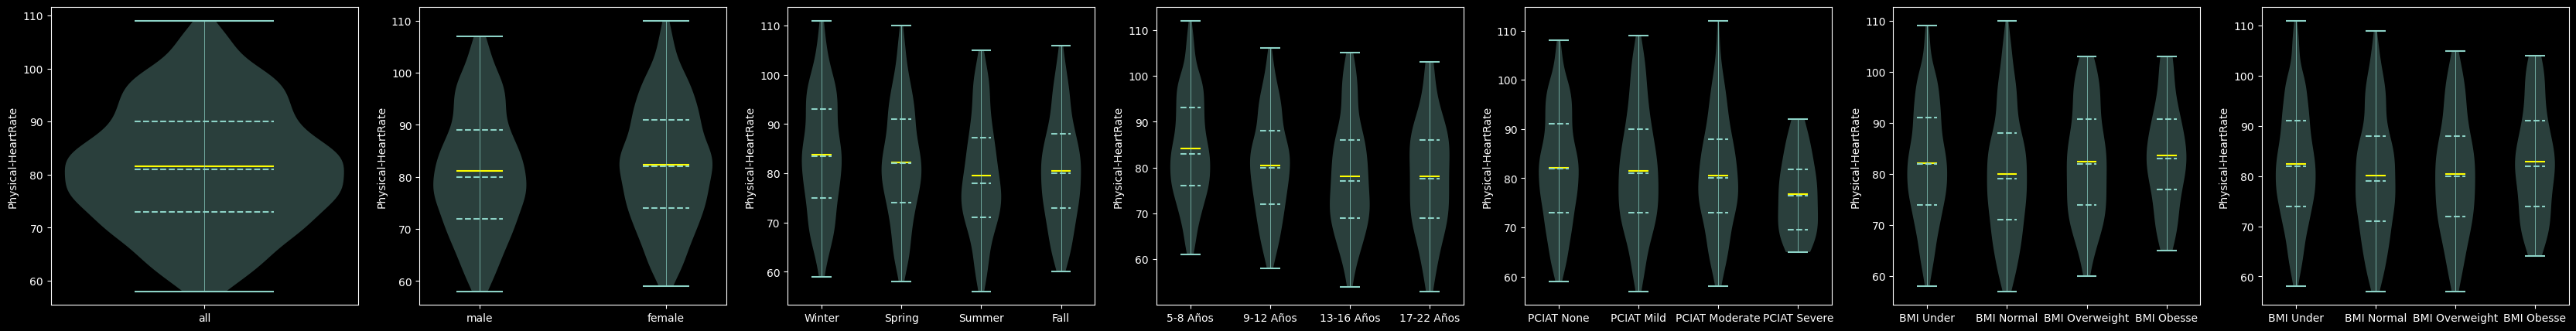

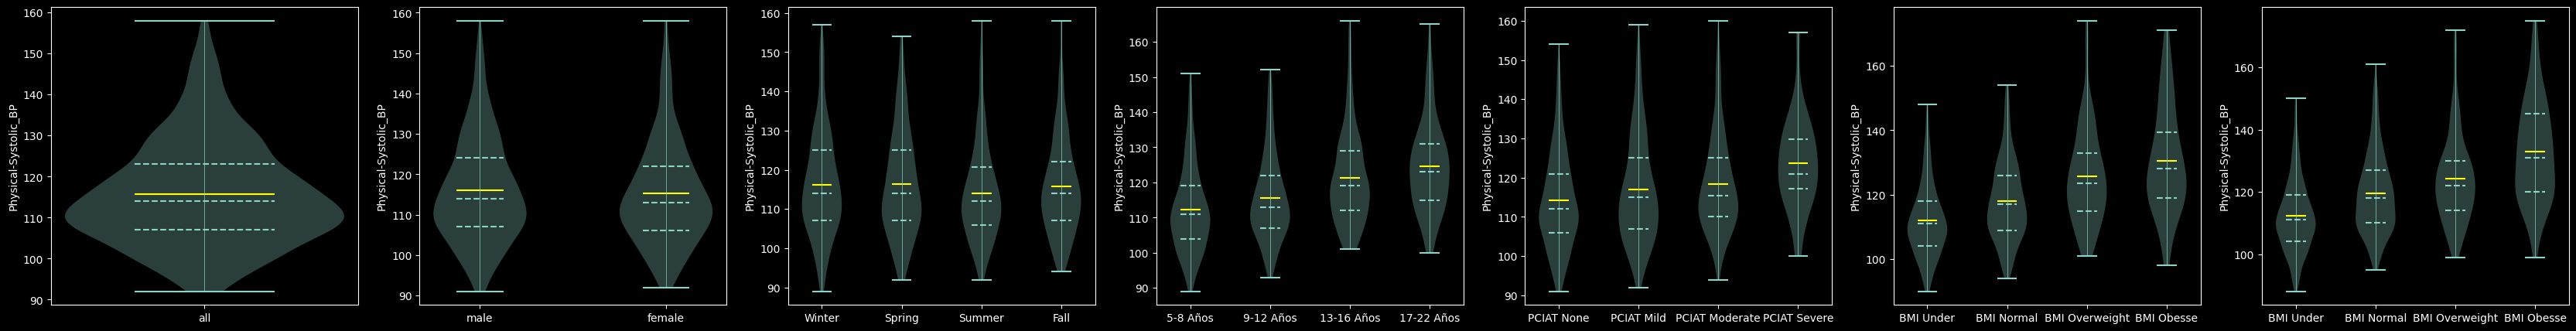

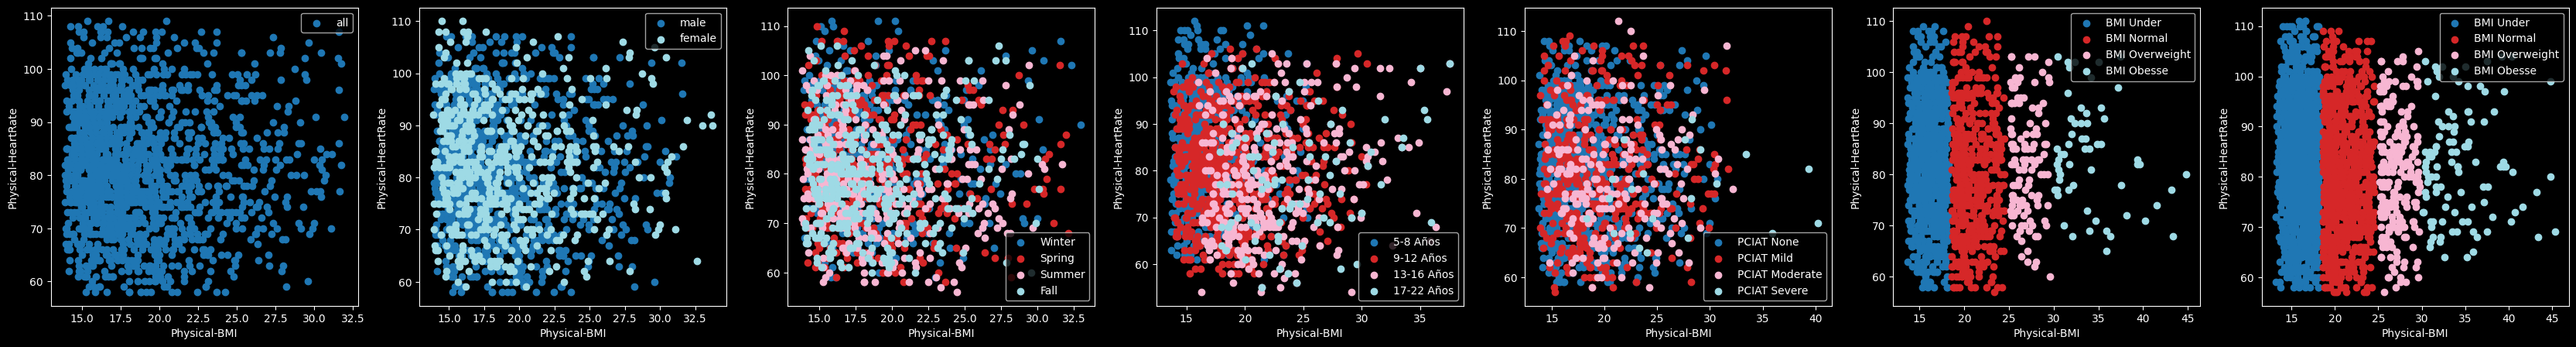

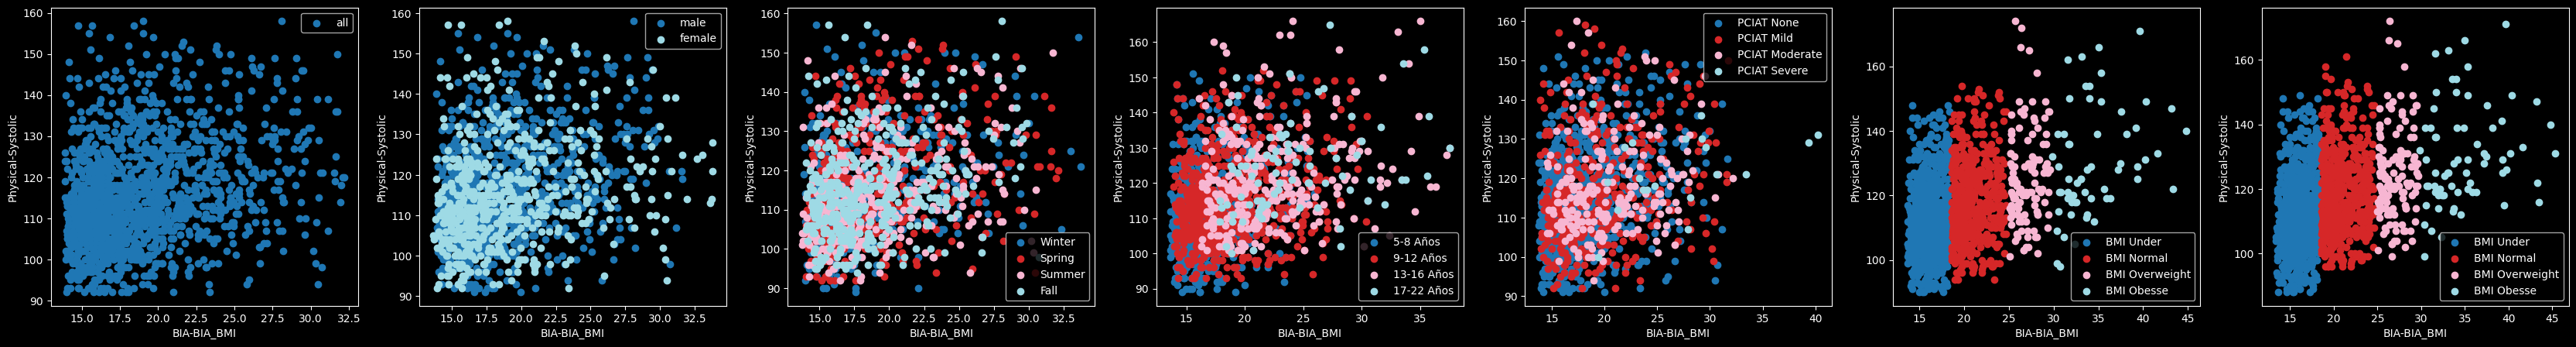

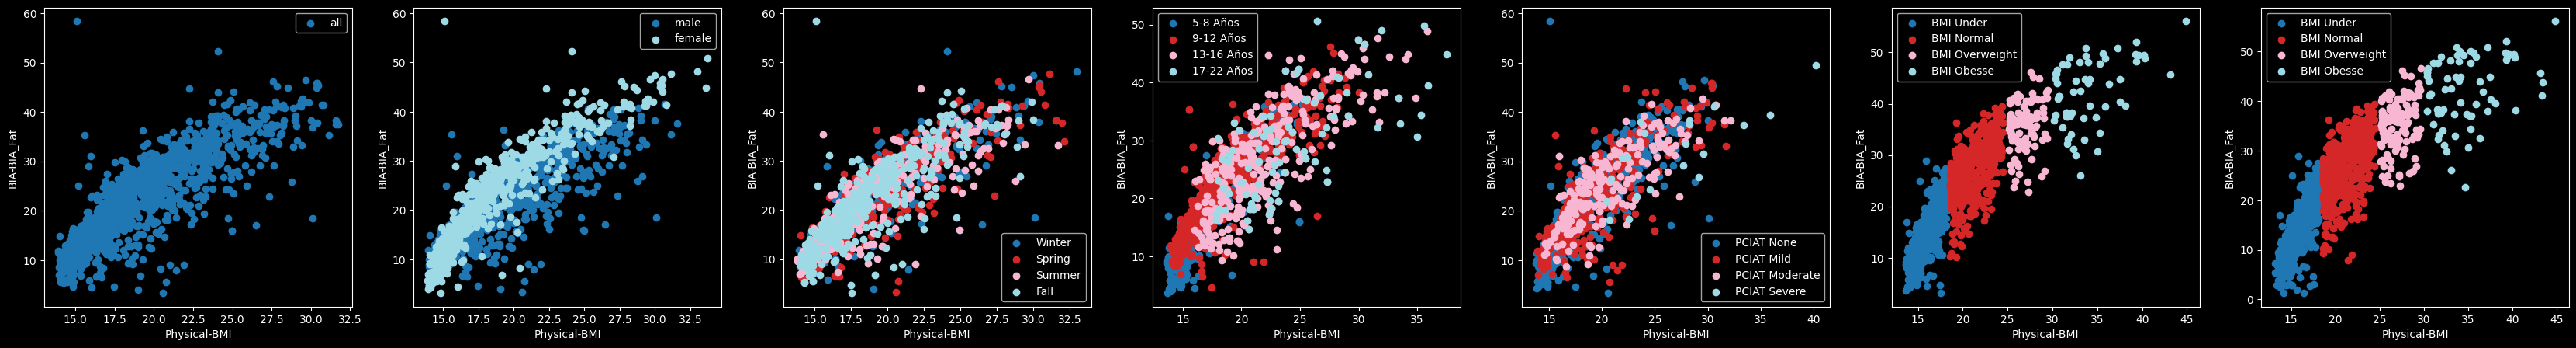

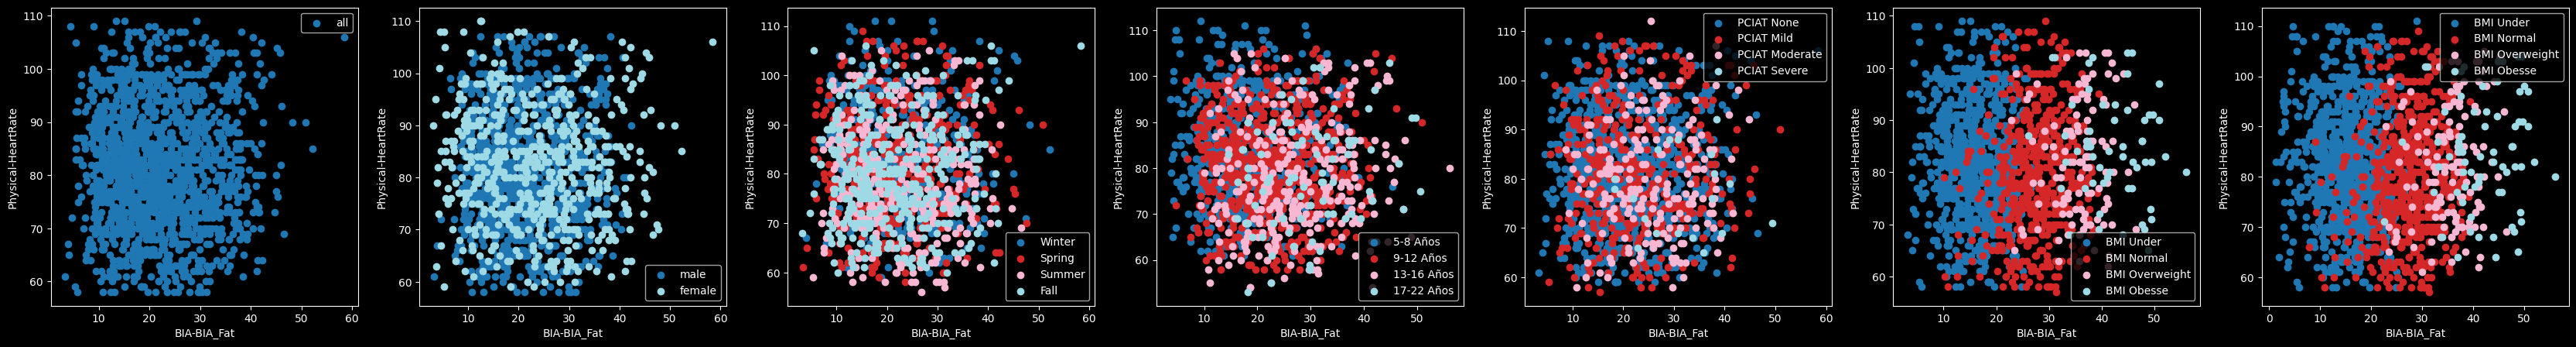

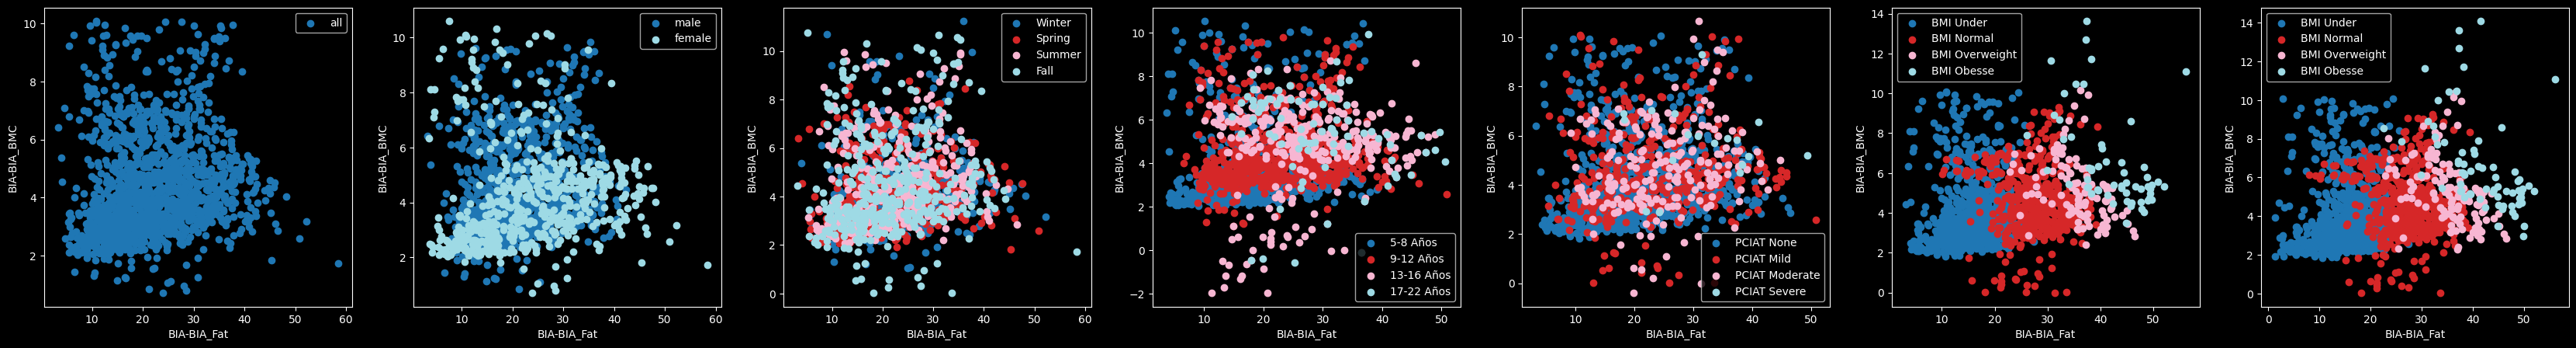

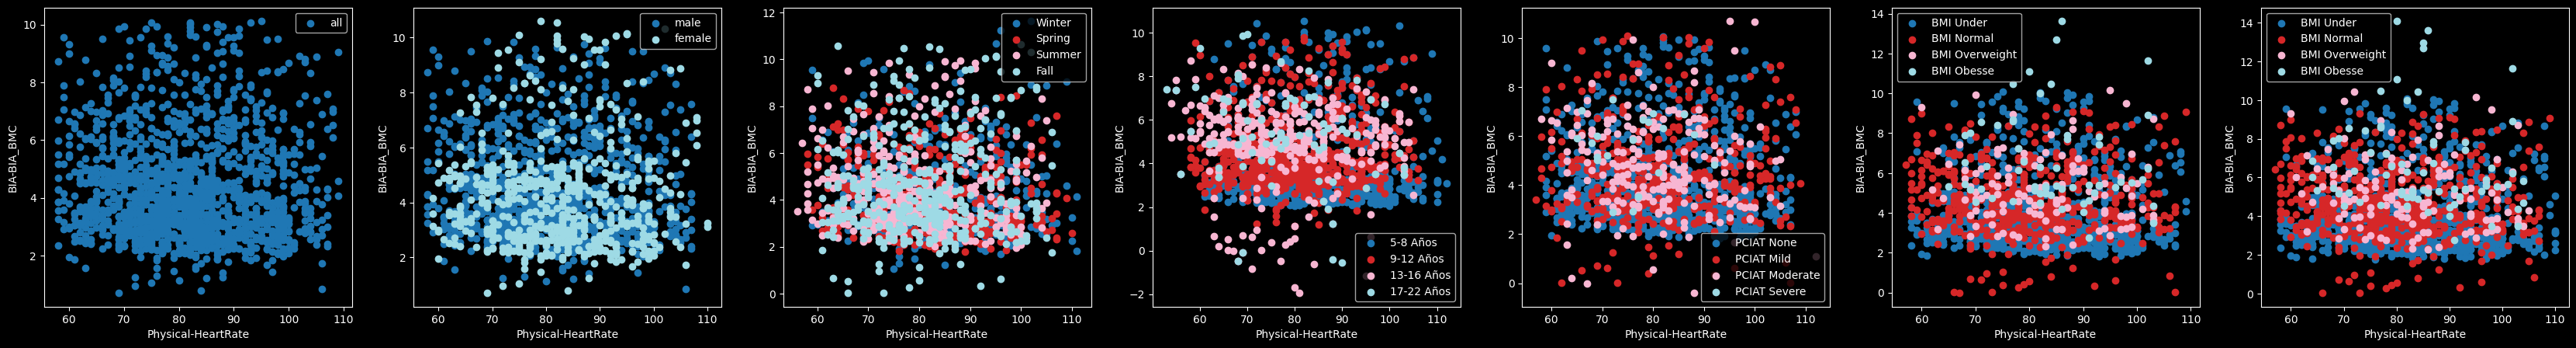

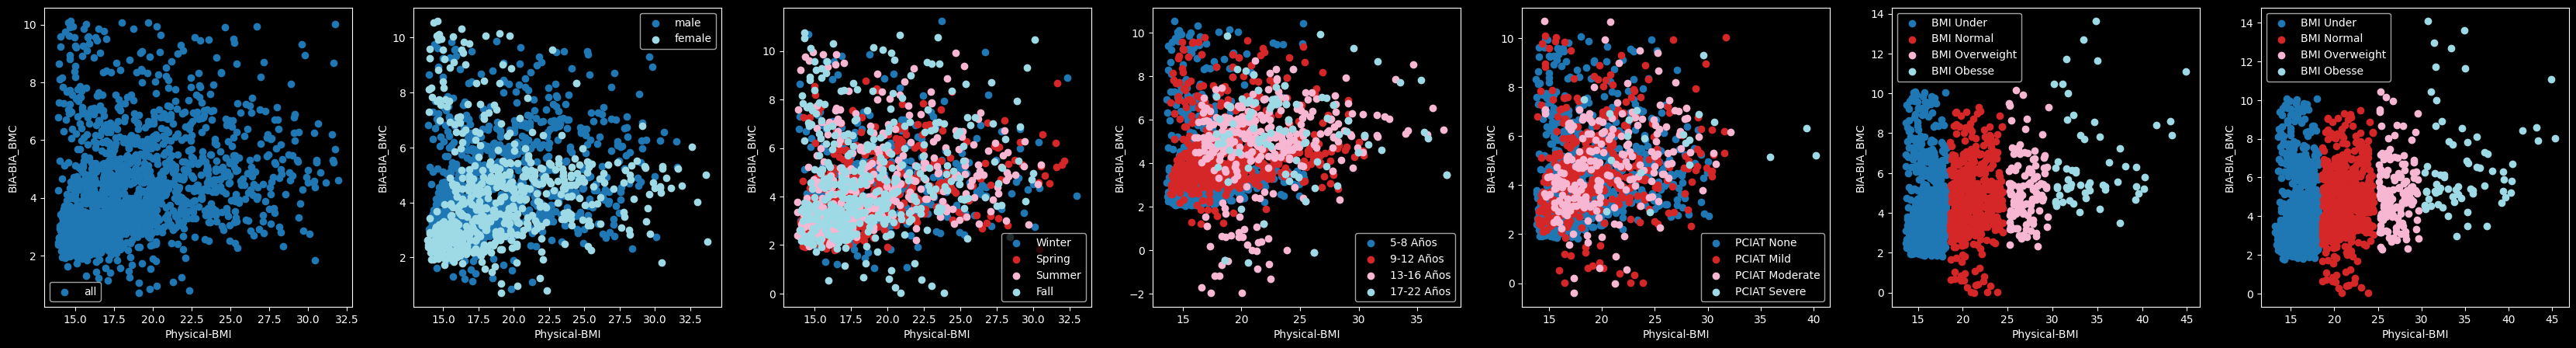

In [485]:
comparative_data: list[dict[str, pd.DataFrame]] = []

# COMPARACIONS 1
data_dict = {"all": data_df}
comparative_data.append(data_dict)

# COMPARACIONS 2
data_dict = {}
data_dict["male"] = data_df[data_df["Basic_Demos-Sex"] == 0]
data_dict["female"] = data_df[data_df["Basic_Demos-Sex"] == 1]
comparative_data.append(data_dict)

# COMPARACIONS 3
data_dict = {}

data_dict["Winter"] = data_df[data_df["Physical-Season"] == "Winter"]
data_dict["Spring"] = data_df[data_df["Physical-Season"] == "Spring"]
data_dict["Summer"] = data_df[data_df["Physical-Season"] == "Summer"]
data_dict["Fall"] = data_df[data_df["Physical-Season"] == "Fall"]
comparative_data.append(data_dict)

# COMPARACIONS 4
data_dict = {}
data_dict["5-8 Años"] = data_df[data_df["Basic_Demos-Age"].between(5, 9)]
data_dict["9-12 Años"] = data_df[data_df["Basic_Demos-Age"].between(9, 13)]
data_dict["13-16 Años"] = data_df[data_df["Basic_Demos-Age"].between(13, 17)]
data_dict["17-22 Años"] = data_df[data_df["Basic_Demos-Age"].between(17, 23)]
comparative_data.append(data_dict)

# COMPARACIONS 5
data_dict = {}
data_dict["PCIAT None"] = data_df[data_df["PCIAT-PCIAT_Total"].between(0, 30)]
data_dict["PCIAT Mild"] = data_df[data_df["PCIAT-PCIAT_Total"].between(31, 49)]
data_dict["PCIAT Moderate"] = data_df[data_df["PCIAT-PCIAT_Total"].between(50, 79)]
data_dict["PCIAT Severe"] = data_df[data_df["PCIAT-PCIAT_Total"].between(80, 100)]
comparative_data.append(data_dict)


# COMPARACIONS 6
data_dict = {}
data_dict["BMI Under"] = data_df[data_df["Physical-BMI"] < 18.4]
data_dict["BMI Normal"] = data_df[data_df["Physical-BMI"].between(18.5, 24.9)]
data_dict["BMI Overweight"] = data_df[data_df["Physical-BMI"].between(25, 29.9)]
data_dict["BMI Obesse"] = data_df[data_df["Physical-BMI"] > 30]
comparative_data.append(data_dict)


for compare_function in compare_functions:
    fig, ax = plt.subplots(1, len(comparative_data), figsize=(len(comparative_data) * 6, 5))
    for i, data_dict in enumerate(comparative_data):
        compare_function(data_dict, ax[i])
